<a href="https://colab.research.google.com/github/EjbejaranosAI/AI_trends_2023/blob/main/MBM_AI_for__analysis_of_brain_image_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI/ML for the analysis of brain imaging data.
## MBM (Minds, brains and machines)
## Author: Edison Jair Bejarano Sepulveda

### Quantitative susceptibility mapping - QSM DATA from 2018 reconstruction challenge

##### *Download data*

In [1]:
# Downloading data
!wget -nc http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
!unzip -uo 20170327_qsm2016_recon_challenge.zip

--2023-06-10 00:07:55--  http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
Resolving www.neuroimaging.at (www.neuroimaging.at)... 81.19.159.35
Connecting to www.neuroimaging.at (www.neuroimaging.at)|81.19.159.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244982259 (234M) [application/zip]
Saving to: ‘20170327_qsm2016_recon_challenge.zip’

20170327_qsm2016_re 100%[===================>] 233.63M  19.0MB/s    in 13s     

2023-06-10 00:08:09 (17.6 MB/s) - ‘20170327_qsm2016_recon_challenge.zip’ saved [244982259/244982259]

Archive:  20170327_qsm2016_recon_challenge.zip
   creating: 20170327_qsm2016_recon_challenge/
   creating: 20170327_qsm2016_recon_challenge/data/
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_33.nii.gz  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.mat  
  inflating: 20170327_qsm2016_recon_challenge/data/chi_cosmos.nii.gz  
  infl

##### *Libraries*

In [2]:
!pip install -q tensorflow==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.0.0-alpha0


In [3]:
# Importing libraries
import os
import pickle
import numpy as np
import nibabel as nib
from tqdm import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import transforms

import tensorflow as tf
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

##### *Utils functions*

In [4]:
# Utils functions

#--------------------------#
# Plot view slices brain 3D
#--------------------------#
def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
    fig = plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(131)
    image = np.take(image_3d, slice_nbr, 2)
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Axial')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    plt.subplot(132)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Coronal')
    plt.xlabel('X-axis')
    plt.ylabel('Z-axis')
    
    plt.subplot(133)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Sagittal')
    plt.xlabel('Y-axis')
    plt.ylabel('Z-axis')
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Intensity', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

#--------------------------#
#       Random size 
#--------------------------#
def creating_random_size(min_size, max_size):
  random_size = np.random.randint(low = min_size, high = max_size)
  return random_size



#--------------------------#
# Susceptibility simulation
#--------------------------#
def simulate_susceptibility_sources(simulation_dim = 160,
                                    rectangles_total = 100, 
                                    spheres_total = 80, 
                                    sus_std = 1,
                                    shape_size_min_factor= 0.01,
                                    shape_size_max_factor = 0.5):
  
  temp_sources = np.zeros((simulation_dim, simulation_dim, simulation_dim))

  for shapes in range(rectangles_total):
    shrink_factor = 1/((shapes/rectangles_total+1))
    shape_size_min = np.floor(simulation_dim * shrink_factor * shape_size_min_factor)
    shape_size_max = np.floor(simulation_dim * shrink_factor * shape_size_max_factor)
    print(f"\n ------- Shape Min size: {shape_size_min} ------- \n")
    print(f"\n ------- Shape Max size: {shape_size_max} ------- \n")

    susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)
    # Creating random sizes
    random_sizex = creating_random_size(shape_size_min,shape_size_max)
    random_sizey = creating_random_size(shape_size_min,shape_size_max)
    random_sizez = creating_random_size(shape_size_min,shape_size_max)
    # Getting axis positions
    x_pos = np.random.randint(simulation_dim)
    y_pos = np.random.randint(simulation_dim)
    z_pos = np.random.randint(simulation_dim)

    x_pos_max = x_pos + random_sizex
    if x_pos_max >= simulation_dim:
      x_pos_max = simulation_dim

    y_pos_max = y_pos + random_sizey
    if y_pos_max >= simulation_dim:
      y_pos_max = simulation_dim 

    z_pos_max = z_pos + random_sizez
    if z_pos_max >= simulation_dim:
      z_pos_max = simulation_dim

    temp_sources[x_pos:x_pos_max, y_pos:y_pos_max, z_pos:z_pos_max] = susceptibility_value

  return temp_sources

import numpy as np



#--------------------------#
#     Dipole kernel 3D
#--------------------------#
def create_dipole_kernel_3D(data_shape, voxel_size, b_vec):
    # Calculate the field of view
    fov = np.array(data_shape) * np.array(voxel_size)
    
    # Generate the x, y, and z coordinates of the image grid and
    # Create a meshgrid of the x, y, and z coordinates
    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                          np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                          np.arange(-data_shape[2] // 2, data_shape[2] // 2))
    
    # Normalize the x, y, and z coordinates by the field of view
    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]
    
    # Calculate the squared distance from the origin
    sq_dist = rx ** 2 + ry ** 2 + rz ** 2
    sq_dist[sq_dist == 0] = 1e-6
    
    # Calculate the dipole kernel
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    kernel = (1/3 - d2)
    
    return kernel


#--------------------------------------#
#   Forward convolution with padding
#--------------------------------------#
def simulate_mri_tissue_phase(sample, padding=20):
    # Pad the sample to avoid wrap-around at the edges
    padded_sample = np.pad(sample, pad_width=padding, mode='constant')

    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(padded_sample.size)
    
    # Perform Fourier transform of the padded sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(padded_sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(padded_sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase_unscaled = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase_unscaled * scaling)

    # Crop the padded regions to match the original sample size
    tissue_phase_cropped = tissue_phase[padding:-padding, padding:-padding, padding:-padding]

    return tissue_phase_cropped


#--------------------------------------#
#     Forward convolution no padding
#--------------------------------------#
def simulate_mri_tissue_phase_no_padding(sample):
    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(sample.size)
    
    # Perform Fourier transform of the sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase * scaling)

    return tissue_phase


In [5]:
#--------------------------------------#
#     Creating batches for data
#--------------------------------------#
def create_batch(dimension, patch_idx, gt_full, fw_full):
    # Get the dimensions of the ground truth data
    x_max, y_max, z_max = gt_full.shape

    # Generate random indices for selecting the patch
    random_indices = np.random.choice(x_max - dimension, 3)
    randomX, randomY, randomZ = random_indices

    # Extract the patch using tuple indexing
    gt_patch = gt_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]
    fw_patch = fw_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]

    # Return the extracted patches
    return gt_patch, fw_patch

##### Images exploration by views

<ipython-input-6-b42306d4fe86>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
<ipython-input-6-b42306d4fe86>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


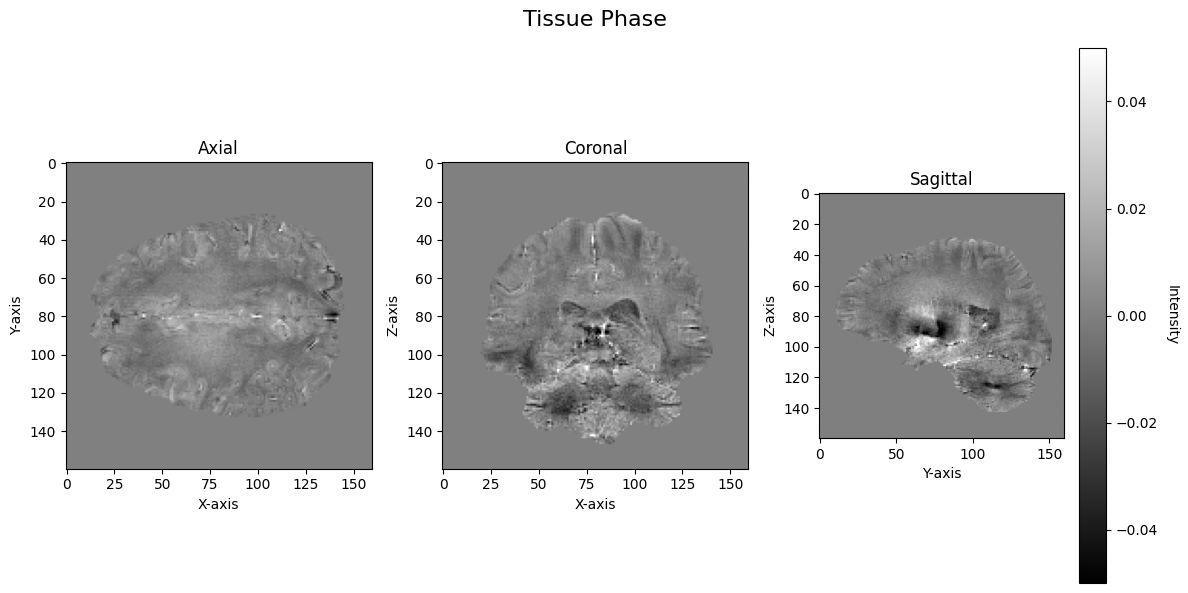

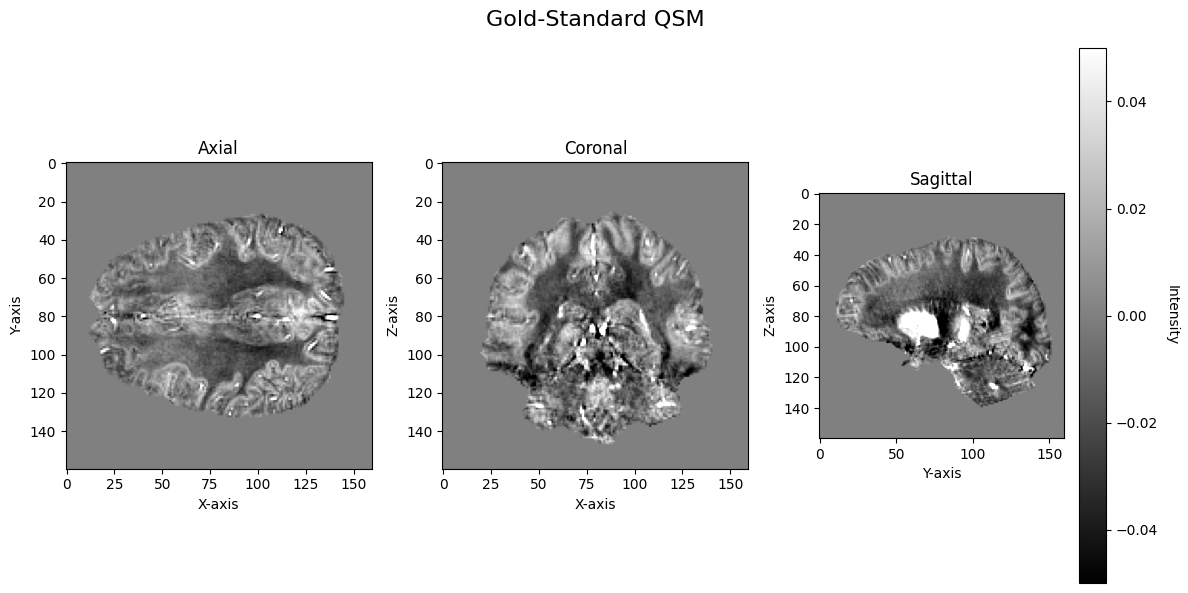

In [6]:
# Loading images by nib library
tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


view_slices_3d(tissue_phase_brain, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(gold_standard_qsm, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Gold-Standard QSM') 

##### *Simulation of susceptibility distribution*


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 160.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 157.0 ------- 


 ------- Shape 

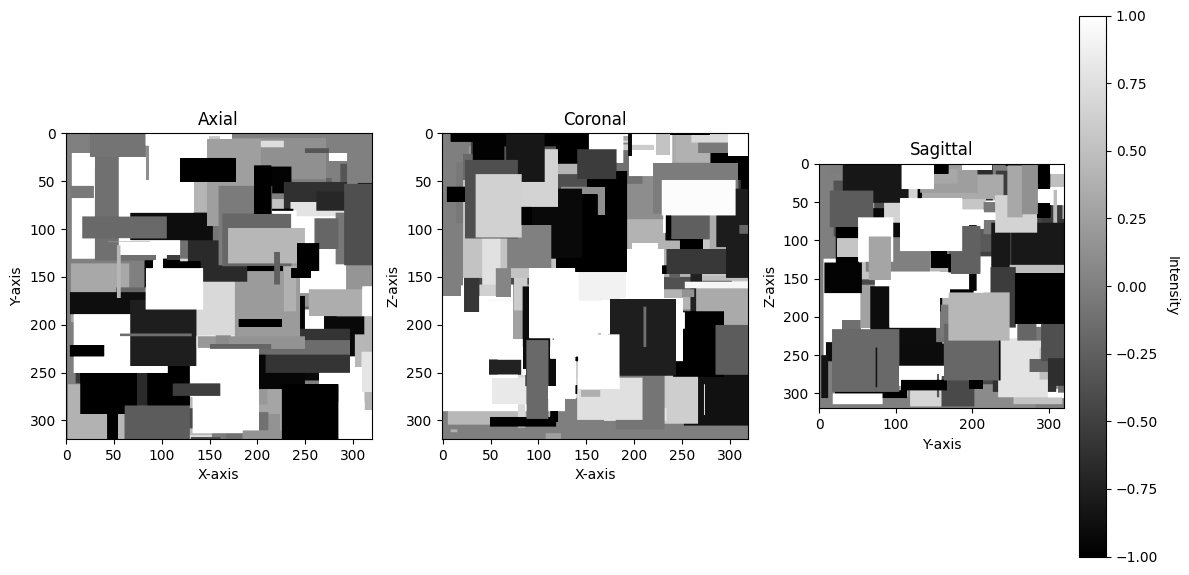

In [7]:
# sim_gt_full = simulated_ground_truth
sim_gt_full = simulate_susceptibility_sources(simulation_dim = 320, rectangles_total = 800, spheres_total = 80,)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

##### *Convolve susceptibility distribution with dipole kernel to yield tissue phase* 


Dipole Kernel: The code generates a 3D dipole kernel using the generate_3d_dipole_kernel function. This kernel represents the response of a magnetic dipole in a magnetic resonance imaging (MRI) system. It is used to model the interaction between the sample and the imaging system.

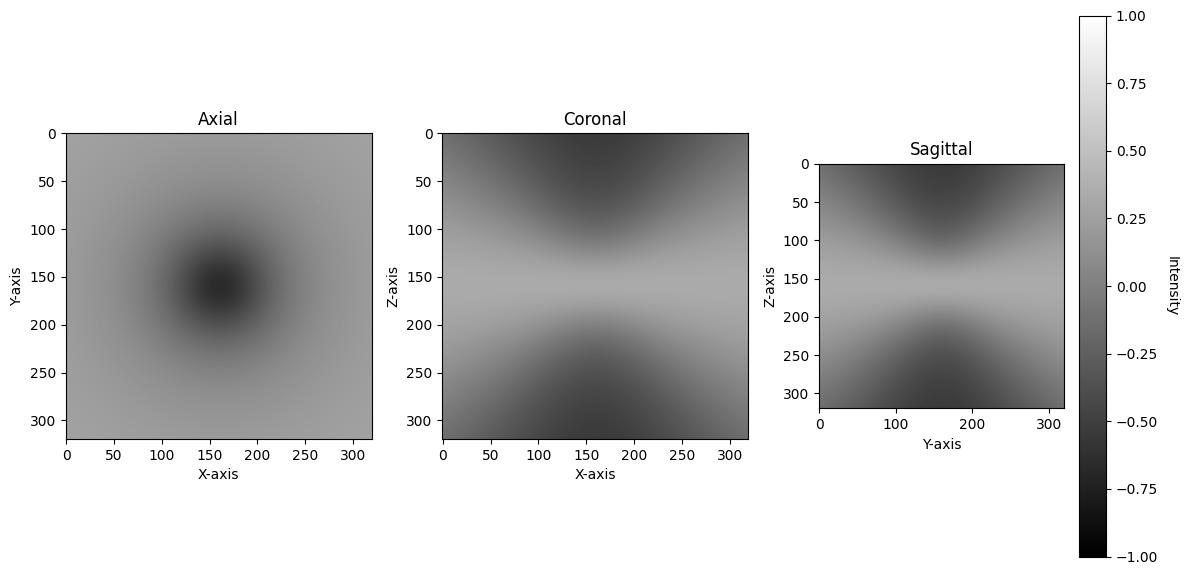

In [8]:
dipole_kernel3d = create_dipole_kernel_3D(sim_gt_full.shape, voxel_size=1, b_vec=[0, 0, 1])
view_slices_3d(dipole_kernel3d, slice_nbr=100, vmin=-1, vmax=1)

- **Fourier Transform:** The code uses the np.fft.fftn function to compute the N-dimensional Fast Fourier Transform (FFT) of the input sample. The np.fft.fftshift function is used to shift the zero-frequency component to the center of the spectrum. This is a common step in Fourier analysis to obtain a more intuitive representation of the data.

- **Inverse Fourier Transform:** The code uses the np.fft.ifftn function to compute the N-dimensional Inverse FFT (IFFT) of the transformed sample. Again, the np.fft.fftshift function is used to shift the zero-frequency component back to the corners of the spectrum.
Scaling: To ensure proper normalization, the code divides the transformed samples by the square root of the sample size (scaling). This step is necessary to preserve the total energy of the data during the Fourier transformations.



- **Multiplication and Convolution:** The code multiplies the transformed sample by the dipole kernel in the Fourier domain. This multiplication corresponds to a convolution operation in the spatial domain. By performing the multiplication in the Fourier domain, the code exploits the convolution theorem, which states that multiplication in the Fourier domain is equivalent to convolution in the spatial domain.

- **Inverse Transform and Rescaling:** After multiplying the transformed sample by the dipole kernel, the code applies the inverse Fourier transform to obtain the spatial representation of the result. The resulting tissue phase is then rescaled by the scaling factor to restore the proper amplitude of the data.

- **Padding and Cropping:** In the forward_convolution_padding function, the input sample is padded with zeros before the Fourier transform to avoid wrap-around artifacts at the edges. After the inverse transform, the padded regions are cropped to match the size of the original sample.

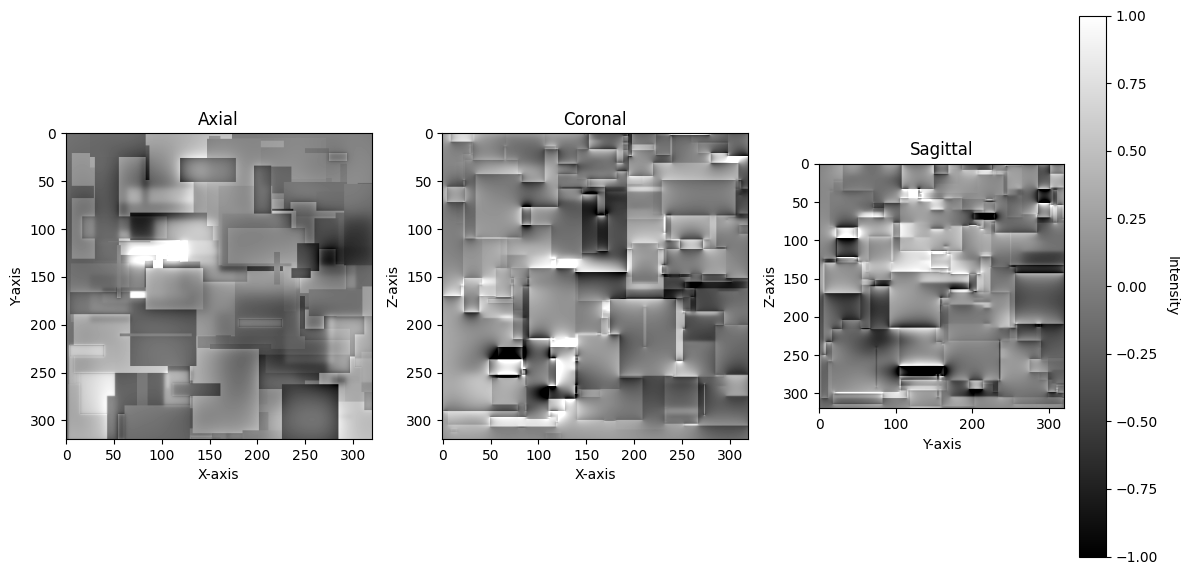

In [9]:
# Simulate tissue phase with padding
simulated_tissue_phase_full = simulate_mri_tissue_phase(sim_gt_full)
view_slices_3d(simulated_tissue_phase_full, slice_nbr=100, vmin=-1, vmax=1)

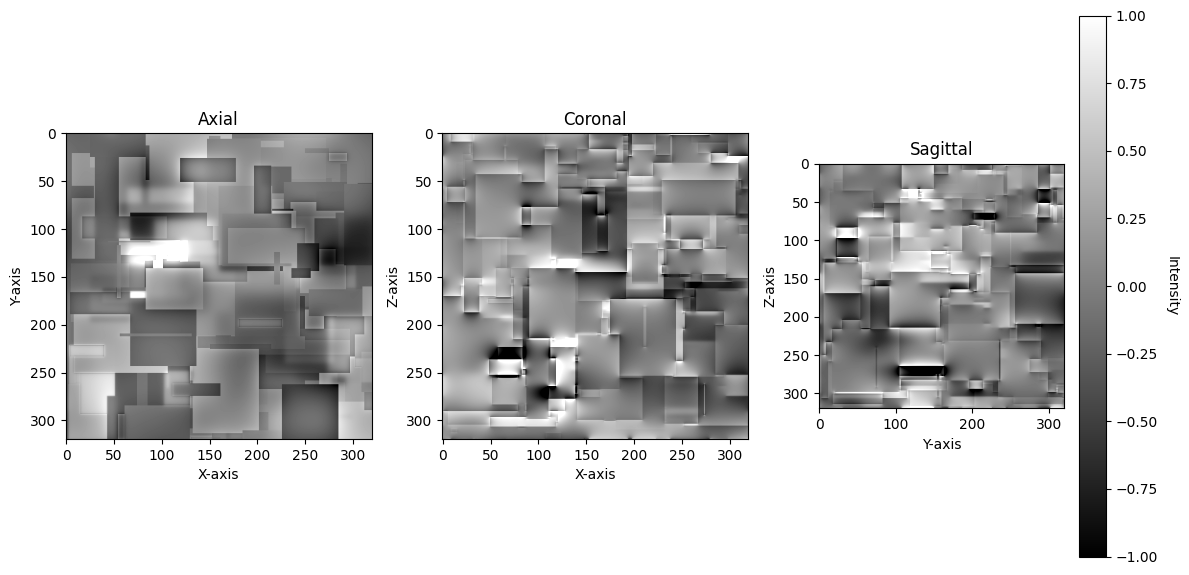

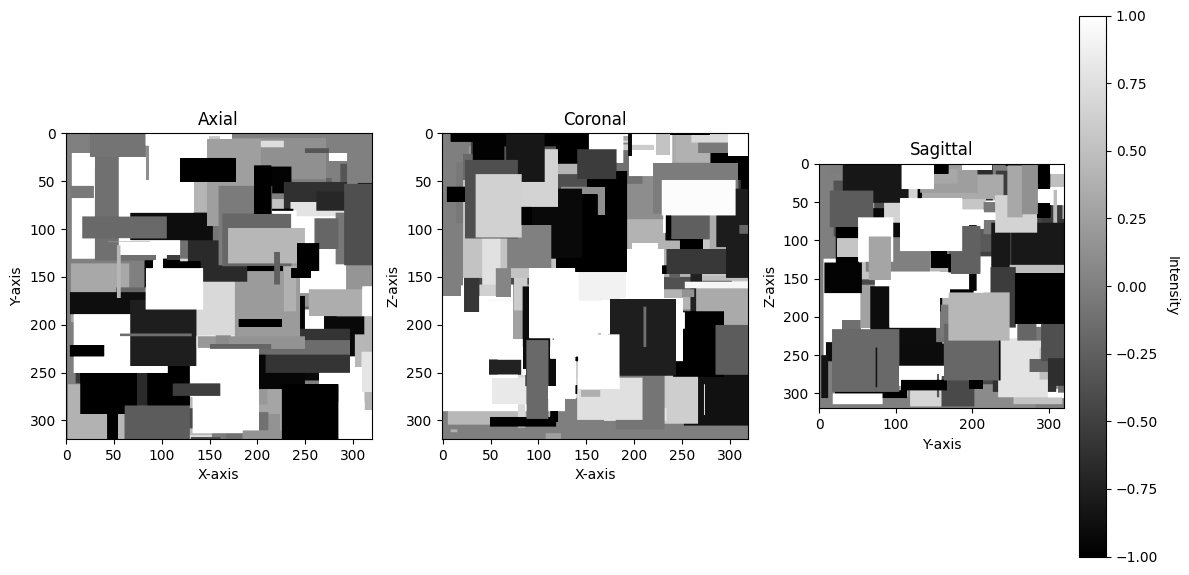

In [10]:
# Simulate tissue phase without padding
simulated_tissue_phase = simulate_mri_tissue_phase_no_padding(sim_gt_full)
view_slices_3d(simulated_tissue_phase, slice_nbr=100, vmin=-1, vmax=1)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

#### Training a model to invert the dipole convolution 

###### Prepare patches for training

In [11]:
total_patches = 500
training_dim = 64

# Split patches to train from our simulations in ground truth and forward
simulation_gt_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))
simulation_fw_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))


for patch_idx in range(total_patches):
  simulation_gt_patches[patch_idx, :, :, :], simulation_fw_patches[patch_idx, :, :, :] = create_batch(training_dim, patch_idx,sim_gt_full,simulated_tissue_phase)


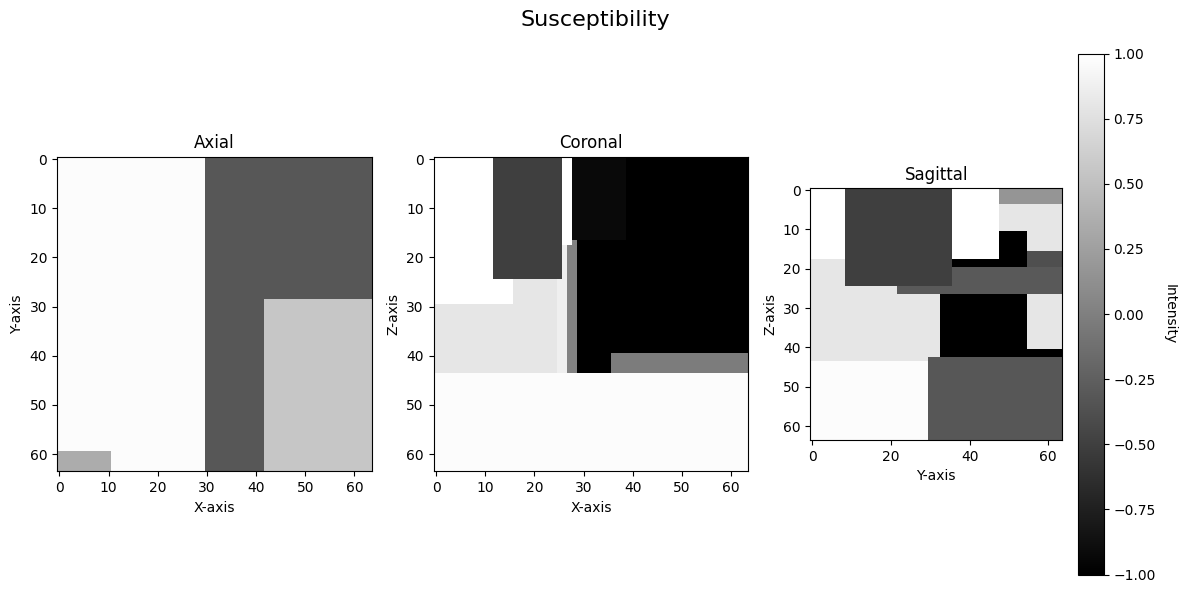

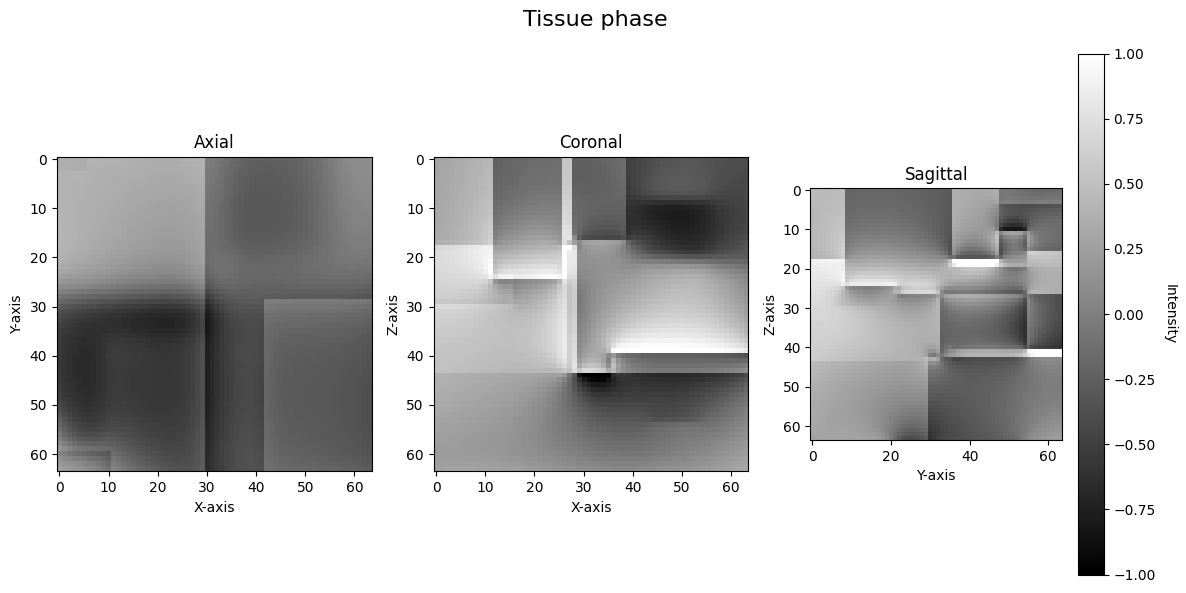

In [12]:
patch_idx = 40
view_slices_3d(simulation_gt_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Susceptibility')
view_slices_3d(simulation_fw_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Tissue phase')

##### Building architectures


In [13]:
# Print TensorFlow version
print(tf.__version__)

# Check GPU device availability
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('Running without GPU acceleration.')

2.12.0
Found GPU at: /device:GPU:0


###### Utils for architectures

In [14]:
# Utils function to construct the model

def downsample(filters, kernel_size, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.LeakyReLU())

    return block


def upsample(filters, kernel_size, apply_dropout=False, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        block.add(tf.keras.layers.Dropout(0.6))
    block.add(tf.keras.layers.ReLU())

    return block



class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        print(f"  - Loss: {logs['loss']:.4f}")
        print(f"  - Mean Squared Error: {logs['mse']:.4f}")


In [15]:
# Testing downsample and upsample functions
inp = simulation_fw_patches[0,:,:,:]
print(f"Origianl shape in fw_pathces: {inp.shape}")
inp = tf.expand_dims(inp,0)
print(f"Expanding shape in fw_pathces first position: {inp.shape}")
inp = tf.expand_dims(inp,4)
print(f"Expanding shape in fw_pathces last position: {inp.shape}")

# Downsample
#(batch,x,y,z,channel)
down_sample = downsample(filters=8, kernel_size=4)
reduction = down_sample(inp)
print(f"Shape in fw_pathces after downsample: {reduction.shape}")

#Upsample
up_sample = upsample(filters=8, kernel_size=4)
expansion = up_sample(reduction)
print(f"Shape in fw_pathces after upsample: {expansion.shape}")

Origianl shape in fw_pathces: (64, 64, 64)
Expanding shape in fw_pathces first position: (1, 64, 64, 64)
Expanding shape in fw_pathces last position: (1, 64, 64, 64, 1)
Shape in fw_pathces after downsample: (1, 32, 32, 32, 8)
Shape in fw_pathces after upsample: (1, 64, 64, 64, 8)


###### ***Parameters***

In [16]:
EPOCHS = 200
PERIOD_TO_STORE = 25
OUTPUT_CHANNELS = 1

###### ***Model 1 - Architecture***

In [17]:
def model_1(filter_base=32, kernel_size=3):
    # Define the downsample blocks
    down_stack = [
        downsample(filter_base, kernel_size, apply_batch_norm=False),  # (base, 32, 32, 32, 64)
        downsample(filter_base * 2, kernel_size),                      # (base, 16, 16, 16, 128)
        downsample(filter_base * 3, kernel_size),                      # (base, 8, 8, 8, 256)
        downsample(filter_base * 4, kernel_size),                      # (base, 4, 4, 4, 512)
        downsample(filter_base * 5, kernel_size),                      # (base, 2, 2, 2, 1024)
    ]

    # Define the upsample blocks
    up_stack = [
        upsample(filter_base * 5, kernel_size, apply_dropout=True),     # (base, 4, 4, 4, 1024)
        upsample(filter_base * 4, kernel_size, apply_dropout=True),     # (base, 8, 8, 8, 512)
        upsample(filter_base * 3, kernel_size, apply_dropout=True),     # (base, 16, 16, 16, 256)
        upsample(filter_base * 2, kernel_size, apply_dropout=True),     # (base, 32, 32, 32, 128)
    ]

    # Define the final layer
    initializer = tf.random_normal_initializer(0., 0.02)
    final_layer = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS,
                                                  kernel_size,
                                                  strides=2,
                                                  padding='same',
                                                  kernel_initializer=initializer,
                                                  activation='tanh')  # (base, 256, 256, 3)

    concatenate = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Reverse the skips for correct order in upsampling

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])

    x = final_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
unet_model1 = model_1()

# Define the learning rate schedule
initial_learning_rate = 0.003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value based on your dataset and training requirements
    decay_rate=0.96  # Adjust this value based on your dataset and training requirements
)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer
unet_model1.compile(loss=losses.mean_squared_error, optimizer=optimizer)
unet_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 sequential_2 (Sequential)      (None, None, None,   864         ['input_1[0][0]']                
                                None, 32)                                                         
                                                                                                  
 sequential_3 (Sequential)      (None, None, None,   55552       ['sequential_2[0][0]']           
                                None, 64)                                                     

###### ***Model 1 - Using the model to predict without training***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 1s 506ms/step
Shape of testing data: (1, 64, 64, 64, 1)


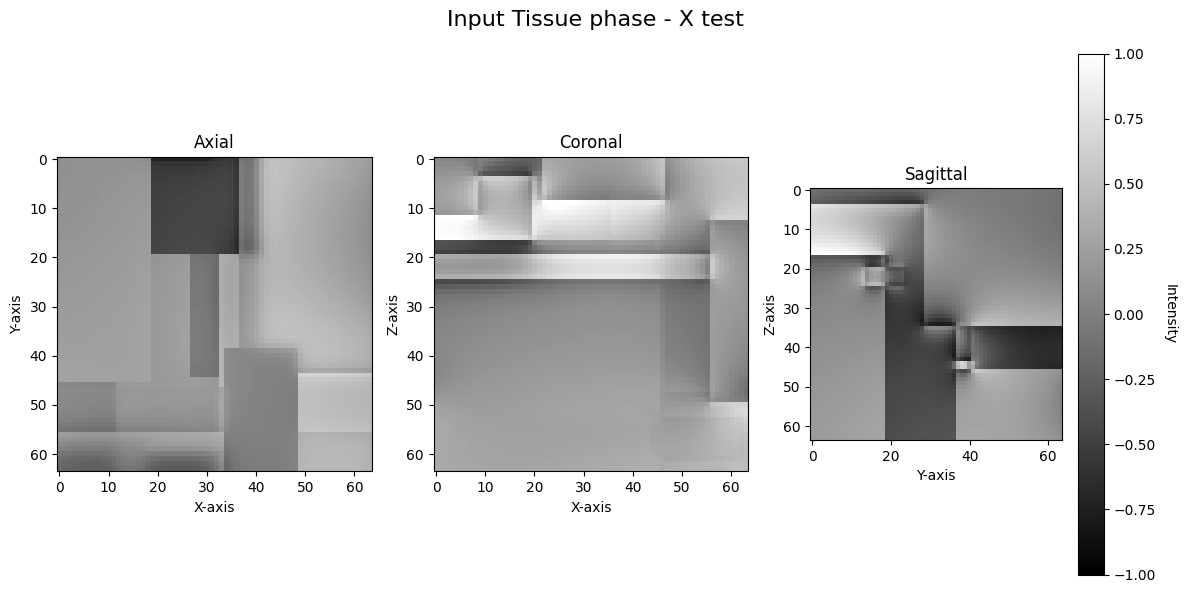

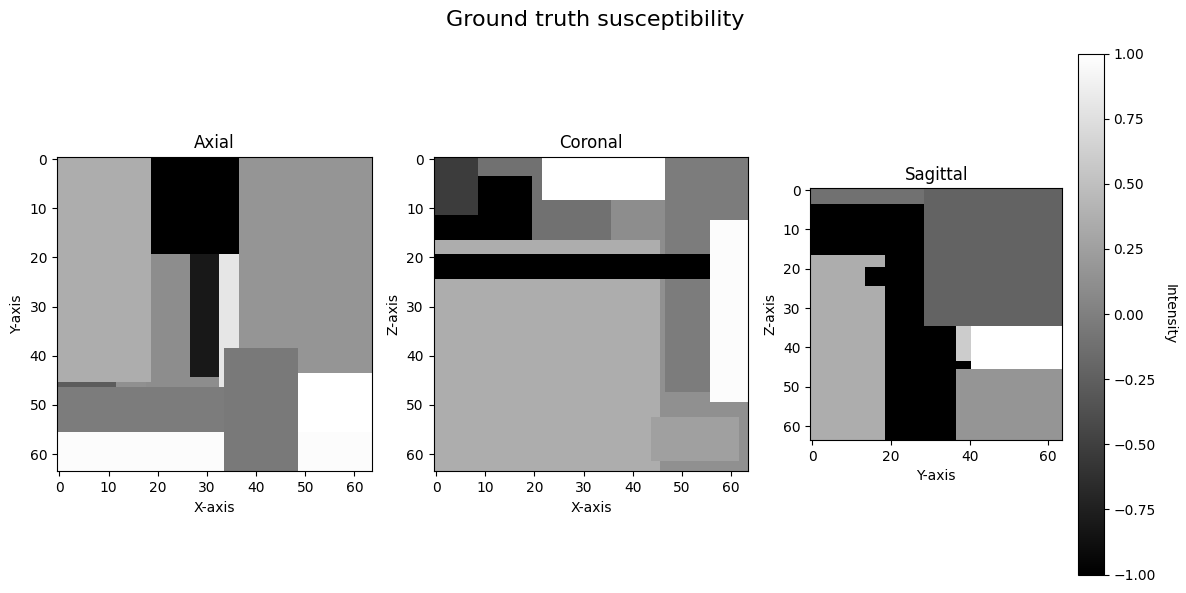

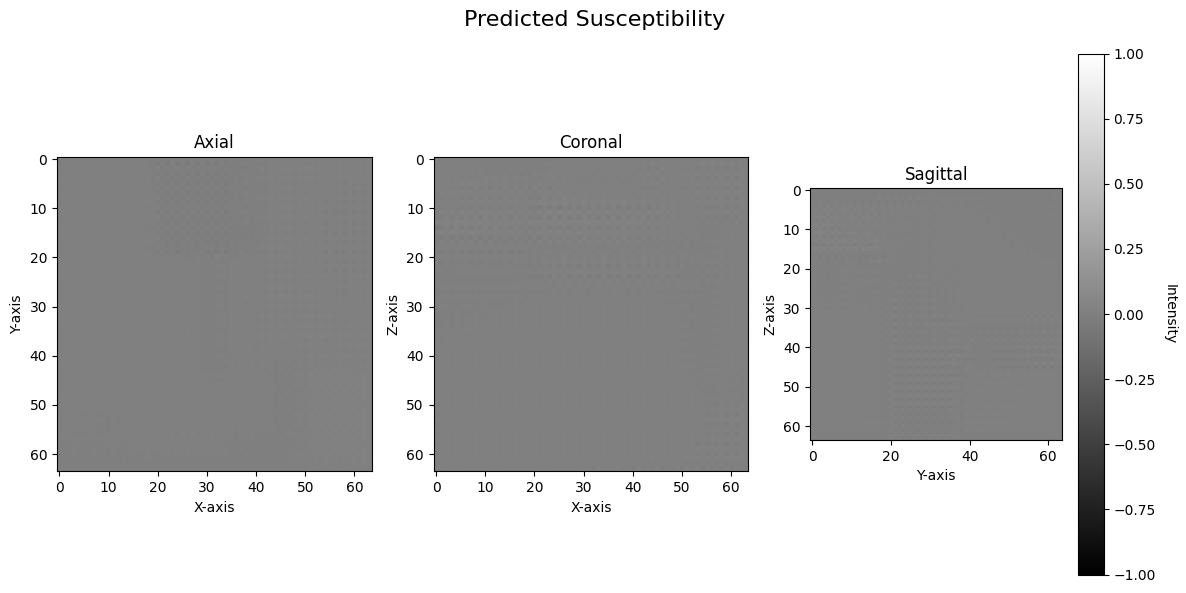

In [19]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model1.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


###### ***Model 1 - Trainning the model***

In [20]:
# Directories to store the checkpoints created
checkpoint_path_1 = "checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path_1)

# Callback to save checkpoints
cp_callback = ModelCheckpoint(
    checkpoint_path_1,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)


early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1
)

# Split data into training and validation sets
validation_split = 0.35
split_index = int(len(simulation_fw_patches) * (1 - validation_split))
train_images = tf.expand_dims(simulation_fw_patches[:split_index], 4)
train_labels = tf.expand_dims(simulation_gt_patches[:split_index], 4)
val_images = tf.expand_dims(simulation_fw_patches[split_index:], 4)
val_labels = tf.expand_dims(simulation_gt_patches[split_index:], 4)


# Train the model with validation data
loss_history_1 = []
with tqdm(total=EPOCHS, desc="Training") as pbar:
    for epoch in range(EPOCHS):
        pbar.set_postfix({'Epoch': epoch+1})
        history_1 = unet_model1.fit(
            train_images,
            train_labels,
            epochs=1,
            batch_size=30,
            shuffle=True,
            validation_data=(val_images, val_labels),
            callbacks=[cp_callback, early_stopping_callback]
        )
        
        loss_history_1.append(history_1.history["loss"][0])
        
        # Clear memory after each epoch
        del history_1
        tf.keras.backend.clear_session()
        
        pbar.update(1)

with open('loss_history_1.pickle', 'wb') as f:
    pickle.dump([loss_history_1, len(loss_history_1)], f)


Training:   0%|          | 0/200 [00:00<?, ?it/s, Epoch=1]

11/11 [==============================] - ETA: 0s - loss: 1.0156
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 17s 703ms/step - loss: 1.0156 - val_loss: 1.0137


Training:   0%|          | 1/200 [00:23<1:18:45, 23.75s/it, Epoch=2]

11/11 [==============================] - ETA: 0s - loss: 0.7755
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 380ms/step - loss: 0.7755 - val_loss: 1.2437


Training:   1%|          | 2/200 [00:28<41:25, 12.55s/it, Epoch=3]

11/11 [==============================] - ETA: 0s - loss: 0.6244
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 377ms/step - loss: 0.6244 - val_loss: 1.1486


Training:   2%|▏         | 3/200 [00:34<30:46,  9.37s/it, Epoch=4]

11/11 [==============================] - ETA: 0s - loss: 0.5193
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 383ms/step - loss: 0.5193 - val_loss: 1.0137


Training:   2%|▏         | 4/200 [00:38<24:49,  7.60s/it, Epoch=5]

11/11 [==============================] - ETA: 0s - loss: 0.4637
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 445ms/step - loss: 0.4637 - val_loss: 0.9618


Training:   2%|▎         | 5/200 [00:44<22:02,  6.78s/it, Epoch=6]

11/11 [==============================] - ETA: 0s - loss: 0.4132
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 7s 505ms/step - loss: 0.4132 - val_loss: 0.8666


Training:   3%|▎         | 6/200 [00:55<27:00,  8.35s/it, Epoch=7]

11/11 [==============================] - ETA: 0s - loss: 0.3815
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 8s 629ms/step - loss: 0.3815 - val_loss: 0.7137


Training:   4%|▎         | 7/200 [01:03<26:21,  8.19s/it, Epoch=8]

11/11 [==============================] - ETA: 0s - loss: 0.3570
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.3570 - val_loss: 0.6543


Training:   4%|▍         | 8/200 [01:09<23:33,  7.36s/it, Epoch=9]

11/11 [==============================] - ETA: 0s - loss: 0.3362
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 475ms/step - loss: 0.3362 - val_loss: 0.5671


Training:   4%|▍         | 9/200 [01:15<22:07,  6.95s/it, Epoch=10]

11/11 [==============================] - ETA: 0s - loss: 0.3194
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 470ms/step - loss: 0.3194 - val_loss: 0.5329


Training:   5%|▌         | 10/200 [01:26<26:22,  8.33s/it, Epoch=11]

11/11 [==============================] - ETA: 0s - loss: 0.3102
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 415ms/step - loss: 0.3102 - val_loss: 0.4923


Training:   6%|▌         | 11/200 [01:32<23:34,  7.48s/it, Epoch=12]

11/11 [==============================] - ETA: 0s - loss: 0.2953
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 402ms/step - loss: 0.2953 - val_loss: 0.4832


Training:   6%|▌         | 12/200 [01:37<21:39,  6.91s/it, Epoch=13]

11/11 [==============================] - ETA: 0s - loss: 0.2862
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2862 - val_loss: 0.4624


Training:   6%|▋         | 13/200 [01:42<19:31,  6.26s/it, Epoch=14]

11/11 [==============================] - ETA: 0s - loss: 0.2852
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 438ms/step - loss: 0.2852 - val_loss: 0.4154


Training:   7%|▋         | 14/200 [01:47<18:29,  5.96s/it, Epoch=15]

11/11 [==============================] - ETA: 0s - loss: 0.2786
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 404ms/step - loss: 0.2786 - val_loss: 0.4446


Training:   8%|▊         | 15/200 [01:54<18:38,  6.04s/it, Epoch=16]

11/11 [==============================] - ETA: 0s - loss: 0.2757
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 381ms/step - loss: 0.2757 - val_loss: 0.4011


Training:   8%|▊         | 16/200 [01:59<18:06,  5.90s/it, Epoch=17]

11/11 [==============================] - ETA: 0s - loss: 0.2652
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 396ms/step - loss: 0.2652 - val_loss: 0.3675


Training:   8%|▊         | 17/200 [02:05<17:42,  5.80s/it, Epoch=18]

11/11 [==============================] - ETA: 0s - loss: 0.2618
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 378ms/step - loss: 0.2618 - val_loss: 0.3659


Training:   9%|▉         | 18/200 [02:09<16:31,  5.45s/it, Epoch=19]

11/11 [==============================] - ETA: 0s - loss: 0.2578
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 416ms/step - loss: 0.2578 - val_loss: 0.3657


Training:  10%|▉         | 19/200 [02:15<16:33,  5.49s/it, Epoch=20]

11/11 [==============================] - ETA: 0s - loss: 0.2533
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 383ms/step - loss: 0.2533 - val_loss: 0.3511


Training:  10%|█         | 20/200 [02:20<15:45,  5.25s/it, Epoch=21]

11/11 [==============================] - ETA: 0s - loss: 0.2498
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 401ms/step - loss: 0.2498 - val_loss: 0.3548


Training:  10%|█         | 21/200 [02:25<15:58,  5.36s/it, Epoch=22]

11/11 [==============================] - ETA: 0s - loss: 0.2505
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 445ms/step - loss: 0.2505 - val_loss: 0.3482


Training:  11%|█         | 22/200 [02:31<16:11,  5.46s/it, Epoch=23]

11/11 [==============================] - ETA: 0s - loss: 0.2487
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 468ms/step - loss: 0.2487 - val_loss: 0.3397


Training:  12%|█▏        | 23/200 [02:36<16:11,  5.49s/it, Epoch=24]

11/11 [==============================] - ETA: 0s - loss: 0.2469
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2469 - val_loss: 0.3367


Training:  12%|█▏        | 24/200 [02:42<16:26,  5.61s/it, Epoch=25]

11/11 [==============================] - ETA: 0s - loss: 0.2462
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 381ms/step - loss: 0.2462 - val_loss: 0.3362


Training:  12%|█▎        | 25/200 [02:47<15:33,  5.33s/it, Epoch=26]

11/11 [==============================] - ETA: 0s - loss: 0.2484
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 444ms/step - loss: 0.2484 - val_loss: 0.3201


Training:  13%|█▎        | 26/200 [02:52<15:27,  5.33s/it, Epoch=27]

11/11 [==============================] - ETA: 0s - loss: 0.2450
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 452ms/step - loss: 0.2450 - val_loss: 0.3123


Training:  14%|█▎        | 27/200 [02:58<15:25,  5.35s/it, Epoch=28]

11/11 [==============================] - ETA: 0s - loss: 0.2425
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 427ms/step - loss: 0.2425 - val_loss: 0.3118


Training:  14%|█▍        | 28/200 [03:03<15:11,  5.30s/it, Epoch=29]

11/11 [==============================] - ETA: 0s - loss: 0.2401
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.2401 - val_loss: 0.3003


Training:  14%|█▍        | 29/200 [03:08<14:37,  5.13s/it, Epoch=30]

11/11 [==============================] - ETA: 0s - loss: 0.2426
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2426 - val_loss: 0.3017


Training:  15%|█▌        | 30/200 [03:12<14:13,  5.02s/it, Epoch=31]

11/11 [==============================] - ETA: 0s - loss: 0.2433
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 450ms/step - loss: 0.2433 - val_loss: 0.2999


Training:  16%|█▌        | 31/200 [03:18<14:26,  5.13s/it, Epoch=32]

11/11 [==============================] - ETA: 0s - loss: 0.2404
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 410ms/step - loss: 0.2404 - val_loss: 0.3032


Training:  16%|█▌        | 32/200 [03:23<14:44,  5.26s/it, Epoch=33]

11/11 [==============================] - ETA: 0s - loss: 0.2395
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 407ms/step - loss: 0.2395 - val_loss: 0.2895


Training:  16%|█▋        | 33/200 [03:29<14:55,  5.36s/it, Epoch=34]

11/11 [==============================] - ETA: 0s - loss: 0.2383
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 422ms/step - loss: 0.2383 - val_loss: 0.2916


Training:  17%|█▋        | 34/200 [03:35<15:00,  5.43s/it, Epoch=35]

11/11 [==============================] - ETA: 0s - loss: 0.2335
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 421ms/step - loss: 0.2335 - val_loss: 0.2895


Training:  18%|█▊        | 35/200 [03:40<15:04,  5.48s/it, Epoch=36]

11/11 [==============================] - ETA: 0s - loss: 0.2310
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.2310 - val_loss: 0.2944


Training:  18%|█▊        | 36/200 [03:46<15:03,  5.51s/it, Epoch=37]

11/11 [==============================] - ETA: 0s - loss: 0.2380
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 404ms/step - loss: 0.2380 - val_loss: 0.2908


Training:  18%|█▊        | 37/200 [03:51<15:02,  5.54s/it, Epoch=38]

11/11 [==============================] - ETA: 0s - loss: 0.2328
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.2328 - val_loss: 0.2881


Training:  19%|█▉        | 38/200 [03:56<14:23,  5.33s/it, Epoch=39]

11/11 [==============================] - ETA: 0s - loss: 0.2299
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 407ms/step - loss: 0.2299 - val_loss: 0.2845


Training:  20%|█▉        | 39/200 [04:02<14:30,  5.41s/it, Epoch=40]

11/11 [==============================] - ETA: 0s - loss: 0.2290
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 396ms/step - loss: 0.2290 - val_loss: 0.2866


Training:  20%|██        | 40/200 [04:08<14:48,  5.55s/it, Epoch=41]

11/11 [==============================] - ETA: 0s - loss: 0.2295
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.2295 - val_loss: 0.2816


Training:  20%|██        | 41/200 [04:12<14:05,  5.32s/it, Epoch=42]

11/11 [==============================] - ETA: 0s - loss: 0.2342
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 410ms/step - loss: 0.2342 - val_loss: 0.2814


Training:  21%|██        | 42/200 [04:17<13:45,  5.22s/it, Epoch=43]

11/11 [==============================] - ETA: 0s - loss: 0.2295
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 393ms/step - loss: 0.2295 - val_loss: 0.2834


Training:  22%|██▏       | 43/200 [04:23<13:57,  5.33s/it, Epoch=44]

11/11 [==============================] - ETA: 0s - loss: 0.2258
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 425ms/step - loss: 0.2258 - val_loss: 0.2782


Training:  22%|██▏       | 44/200 [04:29<14:03,  5.41s/it, Epoch=45]

11/11 [==============================] - ETA: 0s - loss: 0.2233
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 381ms/step - loss: 0.2233 - val_loss: 0.2775


Training:  22%|██▎       | 45/200 [04:34<14:05,  5.46s/it, Epoch=46]

11/11 [==============================] - ETA: 0s - loss: 0.2228
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 399ms/step - loss: 0.2228 - val_loss: 0.2772


Training:  23%|██▎       | 46/200 [04:40<14:06,  5.50s/it, Epoch=47]

11/11 [==============================] - ETA: 0s - loss: 0.2247
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.2247 - val_loss: 0.2780


Training:  24%|██▎       | 47/200 [04:45<14:11,  5.57s/it, Epoch=48]

11/11 [==============================] - ETA: 0s - loss: 0.2262
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2262 - val_loss: 0.2892


Training:  24%|██▍       | 48/200 [04:50<13:28,  5.32s/it, Epoch=49]

11/11 [==============================] - ETA: 0s - loss: 0.2280
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2280 - val_loss: 0.2880


Training:  24%|██▍       | 49/200 [04:55<13:14,  5.26s/it, Epoch=50]

11/11 [==============================] - ETA: 0s - loss: 0.2255
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 386ms/step - loss: 0.2255 - val_loss: 0.2759


Training:  25%|██▌       | 50/200 [05:01<13:26,  5.37s/it, Epoch=51]

11/11 [==============================] - ETA: 0s - loss: 0.2257
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 469ms/step - loss: 0.2257 - val_loss: 0.2730


Training:  26%|██▌       | 51/200 [05:07<13:31,  5.45s/it, Epoch=52]

11/11 [==============================] - ETA: 0s - loss: 0.2231
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 393ms/step - loss: 0.2231 - val_loss: 0.2786


Training:  26%|██▌       | 52/200 [05:12<13:32,  5.49s/it, Epoch=53]

11/11 [==============================] - ETA: 0s - loss: 0.2213
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 422ms/step - loss: 0.2213 - val_loss: 0.2762


Training:  26%|██▋       | 53/200 [05:17<13:09,  5.37s/it, Epoch=54]

11/11 [==============================] - ETA: 0s - loss: 0.2221
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 414ms/step - loss: 0.2221 - val_loss: 0.2763


Training:  27%|██▋       | 54/200 [05:23<13:13,  5.43s/it, Epoch=55]

11/11 [==============================] - ETA: 0s - loss: 0.2207
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 411ms/step - loss: 0.2207 - val_loss: 0.2744


Training:  28%|██▊       | 55/200 [05:28<12:51,  5.32s/it, Epoch=56]

11/11 [==============================] - ETA: 0s - loss: 0.2230
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 386ms/step - loss: 0.2230 - val_loss: 0.2730


Training:  28%|██▊       | 56/200 [05:33<12:37,  5.26s/it, Epoch=57]

11/11 [==============================] - ETA: 0s - loss: 0.2205
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.2205 - val_loss: 0.2730


Training:  28%|██▊       | 57/200 [05:38<12:11,  5.11s/it, Epoch=58]

11/11 [==============================] - ETA: 0s - loss: 0.2203
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 440ms/step - loss: 0.2203 - val_loss: 0.2715


Training:  29%|██▉       | 58/200 [05:43<12:25,  5.25s/it, Epoch=59]

11/11 [==============================] - ETA: 0s - loss: 0.2197
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 384ms/step - loss: 0.2197 - val_loss: 0.2779


Training:  30%|██▉       | 59/200 [05:49<12:39,  5.38s/it, Epoch=60]

11/11 [==============================] - ETA: 0s - loss: 0.2218
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 461ms/step - loss: 0.2218 - val_loss: 0.2668


Training:  30%|███       | 60/200 [05:55<12:42,  5.45s/it, Epoch=61]

11/11 [==============================] - ETA: 0s - loss: 0.2203
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2203 - val_loss: 0.2774


Training:  30%|███       | 61/200 [05:59<12:07,  5.23s/it, Epoch=62]

11/11 [==============================] - ETA: 0s - loss: 0.2225
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2225 - val_loss: 0.2820


Training:  31%|███       | 62/200 [06:04<11:40,  5.08s/it, Epoch=63]

11/11 [==============================] - ETA: 0s - loss: 0.2219
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 396ms/step - loss: 0.2219 - val_loss: 0.2790


Training:  32%|███▏      | 63/200 [06:09<11:40,  5.11s/it, Epoch=64]

11/11 [==============================] - ETA: 0s - loss: 0.2217
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 383ms/step - loss: 0.2217 - val_loss: 0.2718


Training:  32%|███▏      | 64/200 [06:15<11:54,  5.26s/it, Epoch=65]

11/11 [==============================] - ETA: 0s - loss: 0.2216
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 414ms/step - loss: 0.2216 - val_loss: 0.2720


Training:  32%|███▎      | 65/200 [06:21<12:03,  5.36s/it, Epoch=66]

11/11 [==============================] - ETA: 0s - loss: 0.2212
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2212 - val_loss: 0.2702


Training:  33%|███▎      | 66/200 [06:25<11:33,  5.18s/it, Epoch=67]

11/11 [==============================] - ETA: 0s - loss: 0.2172
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 423ms/step - loss: 0.2172 - val_loss: 0.2661


Training:  34%|███▎      | 67/200 [06:30<11:24,  5.15s/it, Epoch=68]

11/11 [==============================] - ETA: 0s - loss: 0.2176
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 382ms/step - loss: 0.2176 - val_loss: 0.2709


Training:  34%|███▍      | 68/200 [06:36<11:38,  5.29s/it, Epoch=69]

11/11 [==============================] - ETA: 0s - loss: 0.2174
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.2174 - val_loss: 0.2690


Training:  34%|███▍      | 69/200 [06:42<11:44,  5.38s/it, Epoch=70]

11/11 [==============================] - ETA: 0s - loss: 0.2201
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.2201 - val_loss: 0.2680


Training:  35%|███▌      | 70/200 [06:47<11:57,  5.52s/it, Epoch=71]

11/11 [==============================] - ETA: 0s - loss: 0.2185
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.2185 - val_loss: 0.2714


Training:  36%|███▌      | 71/200 [06:52<11:21,  5.28s/it, Epoch=72]

11/11 [==============================] - ETA: 0s - loss: 0.2203
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 406ms/step - loss: 0.2203 - val_loss: 0.2710


Training:  36%|███▌      | 72/200 [06:58<11:36,  5.44s/it, Epoch=73]

11/11 [==============================] - ETA: 0s - loss: 0.2190
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2190 - val_loss: 0.2689


Training:  36%|███▋      | 73/200 [07:04<11:36,  5.48s/it, Epoch=74]

11/11 [==============================] - ETA: 0s - loss: 0.2172
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 454ms/step - loss: 0.2172 - val_loss: 0.2685


Training:  37%|███▋      | 74/200 [07:09<11:28,  5.46s/it, Epoch=75]

11/11 [==============================] - ETA: 0s - loss: 0.2159
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 397ms/step - loss: 0.2159 - val_loss: 0.2691


Training:  38%|███▊      | 75/200 [07:14<11:11,  5.37s/it, Epoch=76]

11/11 [==============================] - ETA: 0s - loss: 0.2147
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 421ms/step - loss: 0.2147 - val_loss: 0.2682


Training:  38%|███▊      | 76/200 [07:20<11:24,  5.52s/it, Epoch=77]

11/11 [==============================] - ETA: 0s - loss: 0.2172
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.2172 - val_loss: 0.2669


Training:  38%|███▊      | 77/200 [07:25<10:59,  5.36s/it, Epoch=78]

11/11 [==============================] - ETA: 0s - loss: 0.2150
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 415ms/step - loss: 0.2150 - val_loss: 0.2677


Training:  39%|███▉      | 78/200 [07:30<10:47,  5.31s/it, Epoch=79]

11/11 [==============================] - ETA: 0s - loss: 0.2140
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 395ms/step - loss: 0.2140 - val_loss: 0.2669


Training:  40%|███▉      | 79/200 [07:36<11:07,  5.52s/it, Epoch=80]

11/11 [==============================] - ETA: 0s - loss: 0.2154
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2154 - val_loss: 0.2647


Training:  40%|████      | 80/200 [07:41<10:39,  5.33s/it, Epoch=81]

11/11 [==============================] - ETA: 0s - loss: 0.2166
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 409ms/step - loss: 0.2166 - val_loss: 0.2697


Training:  40%|████      | 81/200 [07:47<10:51,  5.48s/it, Epoch=82]

11/11 [==============================] - ETA: 0s - loss: 0.2140
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2140 - val_loss: 0.2709


Training:  41%|████      | 82/200 [07:53<10:52,  5.53s/it, Epoch=83]

11/11 [==============================] - ETA: 0s - loss: 0.2134
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 420ms/step - loss: 0.2134 - val_loss: 0.2700


Training:  42%|████▏     | 83/200 [07:58<10:49,  5.55s/it, Epoch=84]

11/11 [==============================] - ETA: 0s - loss: 0.2139
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 400ms/step - loss: 0.2139 - val_loss: 0.2678


Training:  42%|████▏     | 84/200 [08:03<10:22,  5.36s/it, Epoch=85]

11/11 [==============================] - ETA: 0s - loss: 0.2155
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 420ms/step - loss: 0.2155 - val_loss: 0.2712


Training:  42%|████▎     | 85/200 [08:08<10:19,  5.39s/it, Epoch=86]

11/11 [==============================] - ETA: 0s - loss: 0.2124
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2124 - val_loss: 0.2663


Training:  43%|████▎     | 86/200 [08:13<09:53,  5.21s/it, Epoch=87]

11/11 [==============================] - ETA: 0s - loss: 0.2142
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 382ms/step - loss: 0.2142 - val_loss: 0.2658


Training:  44%|████▎     | 87/200 [08:19<10:01,  5.32s/it, Epoch=88]

11/11 [==============================] - ETA: 0s - loss: 0.2165
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 383ms/step - loss: 0.2165 - val_loss: 0.2655


Training:  44%|████▍     | 88/200 [08:24<09:48,  5.25s/it, Epoch=89]

11/11 [==============================] - ETA: 0s - loss: 0.2129
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2129 - val_loss: 0.2671


Training:  44%|████▍     | 89/200 [08:29<09:26,  5.10s/it, Epoch=90]

11/11 [==============================] - ETA: 0s - loss: 0.2136
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 417ms/step - loss: 0.2136 - val_loss: 0.2741


Training:  45%|████▌     | 90/200 [08:34<09:36,  5.24s/it, Epoch=91]

11/11 [==============================] - ETA: 0s - loss: 0.2153
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.2153 - val_loss: 0.2680


Training:  46%|████▌     | 91/200 [08:40<09:42,  5.35s/it, Epoch=92]

11/11 [==============================] - ETA: 0s - loss: 0.2137
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 415ms/step - loss: 0.2137 - val_loss: 0.2635


Training:  46%|████▌     | 92/200 [08:45<09:45,  5.42s/it, Epoch=93]

11/11 [==============================] - ETA: 0s - loss: 0.2179
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2179 - val_loss: 0.2688


Training:  46%|████▋     | 93/200 [08:51<09:45,  5.47s/it, Epoch=94]

11/11 [==============================] - ETA: 0s - loss: 0.2152
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 431ms/step - loss: 0.2152 - val_loss: 0.2701


Training:  47%|████▋     | 94/200 [08:56<09:30,  5.38s/it, Epoch=95]

11/11 [==============================] - ETA: 0s - loss: 0.2133
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2133 - val_loss: 0.2666


Training:  48%|████▊     | 95/200 [09:02<09:31,  5.45s/it, Epoch=96]

11/11 [==============================] - ETA: 0s - loss: 0.2147
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 452ms/step - loss: 0.2147 - val_loss: 0.2662


Training:  48%|████▊     | 96/200 [09:07<09:31,  5.49s/it, Epoch=97]

11/11 [==============================] - ETA: 0s - loss: 0.2130
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 479ms/step - loss: 0.2130 - val_loss: 0.2661


Training:  48%|████▊     | 97/200 [09:18<12:15,  7.14s/it, Epoch=98]

11/11 [==============================] - ETA: 0s - loss: 0.2129
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 8s 494ms/step - loss: 0.2129 - val_loss: 0.2658


Training:  49%|████▉     | 98/200 [09:26<12:35,  7.41s/it, Epoch=99]

11/11 [==============================] - ETA: 0s - loss: 0.2139
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 452ms/step - loss: 0.2139 - val_loss: 0.2655


Training:  50%|████▉     | 99/200 [09:32<11:28,  6.82s/it, Epoch=100]

11/11 [==============================] - ETA: 0s - loss: 0.2132
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2132 - val_loss: 0.2684


Training:  50%|█████     | 100/200 [09:37<10:33,  6.34s/it, Epoch=101]

11/11 [==============================] - ETA: 0s - loss: 0.2128
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 380ms/step - loss: 0.2128 - val_loss: 0.2650


Training:  50%|█████     | 101/200 [09:42<09:38,  5.84s/it, Epoch=102]

11/11 [==============================] - ETA: 0s - loss: 0.2146
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 471ms/step - loss: 0.2146 - val_loss: 0.2758


Training:  51%|█████     | 102/200 [09:47<09:24,  5.76s/it, Epoch=103]

11/11 [==============================] - ETA: 0s - loss: 0.2129
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2129 - val_loss: 0.2645


Training:  52%|█████▏    | 103/200 [09:53<09:14,  5.72s/it, Epoch=104]

11/11 [==============================] - ETA: 0s - loss: 0.2123
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 421ms/step - loss: 0.2123 - val_loss: 0.2617


Training:  52%|█████▏    | 104/200 [09:59<09:05,  5.68s/it, Epoch=105]

11/11 [==============================] - ETA: 0s - loss: 0.2122
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.2122 - val_loss: 0.2645


Training:  52%|█████▎    | 105/200 [10:04<08:56,  5.65s/it, Epoch=106]

11/11 [==============================] - ETA: 0s - loss: 0.2127
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 415ms/step - loss: 0.2127 - val_loss: 0.2615


Training:  53%|█████▎    | 106/200 [10:10<08:49,  5.63s/it, Epoch=107]

11/11 [==============================] - ETA: 0s - loss: 0.2119
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 383ms/step - loss: 0.2119 - val_loss: 0.2642


Training:  54%|█████▎    | 107/200 [10:15<08:42,  5.61s/it, Epoch=108]

11/11 [==============================] - ETA: 0s - loss: 0.2129
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2129 - val_loss: 0.2625


Training:  54%|█████▍    | 108/200 [10:21<08:35,  5.60s/it, Epoch=109]

11/11 [==============================] - ETA: 0s - loss: 0.2123
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 426ms/step - loss: 0.2123 - val_loss: 0.2645


Training:  55%|█████▍    | 109/200 [10:26<08:23,  5.53s/it, Epoch=110]

11/11 [==============================] - ETA: 0s - loss: 0.2115
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 378ms/step - loss: 0.2115 - val_loss: 0.2675


Training:  55%|█████▌    | 110/200 [10:31<07:56,  5.30s/it, Epoch=111]

11/11 [==============================] - ETA: 0s - loss: 0.2112
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 404ms/step - loss: 0.2112 - val_loss: 0.2620


Training:  56%|█████▌    | 111/200 [10:36<07:43,  5.21s/it, Epoch=112]

11/11 [==============================] - ETA: 0s - loss: 0.2111
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 382ms/step - loss: 0.2111 - val_loss: 0.2664


Training:  56%|█████▌    | 112/200 [10:42<07:48,  5.32s/it, Epoch=113]

11/11 [==============================] - ETA: 0s - loss: 0.2107
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 419ms/step - loss: 0.2107 - val_loss: 0.2670


Training:  56%|█████▋    | 113/200 [10:47<07:36,  5.25s/it, Epoch=114]

11/11 [==============================] - ETA: 0s - loss: 0.2134
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 386ms/step - loss: 0.2134 - val_loss: 0.2693


Training:  57%|█████▋    | 114/200 [10:52<07:40,  5.35s/it, Epoch=115]

11/11 [==============================] - ETA: 0s - loss: 0.2112
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 418ms/step - loss: 0.2112 - val_loss: 0.2620


Training:  57%|█████▊    | 115/200 [10:58<07:40,  5.42s/it, Epoch=116]

11/11 [==============================] - ETA: 0s - loss: 0.2109
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 417ms/step - loss: 0.2109 - val_loss: 0.2656


Training:  58%|█████▊    | 116/200 [11:03<07:26,  5.31s/it, Epoch=117]

11/11 [==============================] - ETA: 0s - loss: 0.2122
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2122 - val_loss: 0.2653


Training:  58%|█████▊    | 117/200 [11:08<07:28,  5.40s/it, Epoch=118]

11/11 [==============================] - ETA: 0s - loss: 0.2107
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 454ms/step - loss: 0.2107 - val_loss: 0.2636


Training:  59%|█████▉    | 118/200 [11:14<07:32,  5.52s/it, Epoch=119]

11/11 [==============================] - ETA: 0s - loss: 0.2107
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2107 - val_loss: 0.2664


Training:  60%|█████▉    | 119/200 [11:20<07:28,  5.54s/it, Epoch=120]

11/11 [==============================] - ETA: 0s - loss: 0.2087
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 455ms/step - loss: 0.2087 - val_loss: 0.2615


Training:  60%|██████    | 120/200 [11:26<07:31,  5.65s/it, Epoch=121]

11/11 [==============================] - ETA: 0s - loss: 0.2087
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 384ms/step - loss: 0.2087 - val_loss: 0.2661


Training:  60%|██████    | 121/200 [11:30<07:03,  5.36s/it, Epoch=122]

11/11 [==============================] - ETA: 0s - loss: 0.2088
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 411ms/step - loss: 0.2088 - val_loss: 0.2643


Training:  61%|██████    | 122/200 [11:35<06:49,  5.25s/it, Epoch=123]

11/11 [==============================] - ETA: 0s - loss: 0.2092
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2092 - val_loss: 0.2654


Training:  62%|██████▏   | 123/200 [11:41<06:52,  5.35s/it, Epoch=124]

11/11 [==============================] - ETA: 0s - loss: 0.2121
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 461ms/step - loss: 0.2121 - val_loss: 0.2691


Training:  62%|██████▏   | 124/200 [11:47<06:52,  5.42s/it, Epoch=125]

11/11 [==============================] - ETA: 0s - loss: 0.2105
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 380ms/step - loss: 0.2105 - val_loss: 0.2666


Training:  62%|██████▎   | 125/200 [11:51<06:30,  5.21s/it, Epoch=126]

11/11 [==============================] - ETA: 0s - loss: 0.2101
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2101 - val_loss: 0.2650


Training:  63%|██████▎   | 126/200 [11:56<06:16,  5.08s/it, Epoch=127]

11/11 [==============================] - ETA: 0s - loss: 0.2098
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 419ms/step - loss: 0.2098 - val_loss: 0.2656


Training:  64%|██████▎   | 127/200 [12:02<06:21,  5.23s/it, Epoch=128]

11/11 [==============================] - ETA: 0s - loss: 0.2102
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 383ms/step - loss: 0.2102 - val_loss: 0.2664


Training:  64%|██████▍   | 128/200 [12:07<06:24,  5.34s/it, Epoch=129]

11/11 [==============================] - ETA: 0s - loss: 0.2111
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 410ms/step - loss: 0.2111 - val_loss: 0.2637


Training:  64%|██████▍   | 129/200 [12:12<06:10,  5.22s/it, Epoch=130]

11/11 [==============================] - ETA: 0s - loss: 0.2126
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 408ms/step - loss: 0.2126 - val_loss: 0.2651


Training:  65%|██████▌   | 130/200 [12:17<06:00,  5.15s/it, Epoch=131]

11/11 [==============================] - ETA: 0s - loss: 0.2116
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 412ms/step - loss: 0.2116 - val_loss: 0.2664


Training:  66%|██████▌   | 131/200 [12:23<06:04,  5.29s/it, Epoch=132]

11/11 [==============================] - ETA: 0s - loss: 0.2097
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 383ms/step - loss: 0.2097 - val_loss: 0.2658


Training:  66%|██████▌   | 132/200 [12:29<06:07,  5.40s/it, Epoch=133]

11/11 [==============================] - ETA: 0s - loss: 0.2093
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 383ms/step - loss: 0.2093 - val_loss: 0.2634


Training:  66%|██████▋   | 133/200 [12:33<05:47,  5.19s/it, Epoch=134]

11/11 [==============================] - ETA: 0s - loss: 0.2099
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 411ms/step - loss: 0.2099 - val_loss: 0.2714


Training:  67%|██████▋   | 134/200 [12:39<05:44,  5.22s/it, Epoch=135]

11/11 [==============================] - ETA: 0s - loss: 0.2118
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 380ms/step - loss: 0.2118 - val_loss: 0.2652


Training:  68%|██████▊   | 135/200 [12:44<05:46,  5.33s/it, Epoch=136]

11/11 [==============================] - ETA: 0s - loss: 0.2127
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 459ms/step - loss: 0.2127 - val_loss: 0.2635


Training:  68%|██████▊   | 136/200 [12:50<05:42,  5.35s/it, Epoch=137]

11/11 [==============================] - ETA: 0s - loss: 0.2113
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 378ms/step - loss: 0.2113 - val_loss: 0.2629


Training:  68%|██████▊   | 137/200 [12:55<05:41,  5.42s/it, Epoch=138]

11/11 [==============================] - ETA: 0s - loss: 0.2091
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 400ms/step - loss: 0.2091 - val_loss: 0.2601


Training:  69%|██████▉   | 138/200 [13:00<05:27,  5.28s/it, Epoch=139]

11/11 [==============================] - ETA: 0s - loss: 0.2091
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 443ms/step - loss: 0.2091 - val_loss: 0.2623


Training:  70%|██████▉   | 139/200 [13:06<05:30,  5.41s/it, Epoch=140]

11/11 [==============================] - ETA: 0s - loss: 0.2078
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2078 - val_loss: 0.2632


Training:  70%|███████   | 140/200 [13:11<05:12,  5.21s/it, Epoch=141]

11/11 [==============================] - ETA: 0s - loss: 0.2096
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 416ms/step - loss: 0.2096 - val_loss: 0.2656


Training:  70%|███████   | 141/200 [13:16<05:14,  5.33s/it, Epoch=142]

11/11 [==============================] - ETA: 0s - loss: 0.2084
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2084 - val_loss: 0.2692


Training:  71%|███████   | 142/200 [13:22<05:14,  5.42s/it, Epoch=143]

11/11 [==============================] - ETA: 0s - loss: 0.2074
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 420ms/step - loss: 0.2074 - val_loss: 0.2621


Training:  72%|███████▏  | 143/200 [13:27<05:11,  5.47s/it, Epoch=144]

11/11 [==============================] - ETA: 0s - loss: 0.2079
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 384ms/step - loss: 0.2079 - val_loss: 0.2648


Training:  72%|███████▏  | 144/200 [13:33<05:08,  5.51s/it, Epoch=145]

11/11 [==============================] - ETA: 0s - loss: 0.2080
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 464ms/step - loss: 0.2080 - val_loss: 0.2680


Training:  72%|███████▎  | 145/200 [13:39<05:04,  5.53s/it, Epoch=146]

11/11 [==============================] - ETA: 0s - loss: 0.2080
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.2080 - val_loss: 0.2715


Training:  73%|███████▎  | 146/200 [13:44<04:59,  5.55s/it, Epoch=147]

11/11 [==============================] - ETA: 0s - loss: 0.2078
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 459ms/step - loss: 0.2078 - val_loss: 0.2664


Training:  74%|███████▎  | 147/200 [13:50<04:53,  5.53s/it, Epoch=148]

11/11 [==============================] - ETA: 0s - loss: 0.2089
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2089 - val_loss: 0.2666


Training:  74%|███████▍  | 148/200 [13:55<04:39,  5.37s/it, Epoch=149]

11/11 [==============================] - ETA: 0s - loss: 0.2092
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2092 - val_loss: 0.2672


Training:  74%|███████▍  | 149/200 [13:59<04:25,  5.20s/it, Epoch=150]

11/11 [==============================] - ETA: 0s - loss: 0.2107
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 418ms/step - loss: 0.2107 - val_loss: 0.2674


Training:  75%|███████▌  | 150/200 [14:04<04:17,  5.15s/it, Epoch=151]

11/11 [==============================] - ETA: 0s - loss: 0.2120
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 378ms/step - loss: 0.2120 - val_loss: 0.2731


Training:  76%|███████▌  | 151/200 [14:10<04:19,  5.29s/it, Epoch=152]

11/11 [==============================] - ETA: 0s - loss: 0.2124
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 417ms/step - loss: 0.2124 - val_loss: 0.2659


Training:  76%|███████▌  | 152/200 [14:16<04:18,  5.38s/it, Epoch=153]

11/11 [==============================] - ETA: 0s - loss: 0.2105
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2105 - val_loss: 0.2657


Training:  76%|███████▋  | 153/200 [14:21<04:15,  5.45s/it, Epoch=154]

11/11 [==============================] - ETA: 0s - loss: 0.2091
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 427ms/step - loss: 0.2091 - val_loss: 0.2651


Training:  77%|███████▋  | 154/200 [14:27<04:12,  5.49s/it, Epoch=155]

11/11 [==============================] - ETA: 0s - loss: 0.2097
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 382ms/step - loss: 0.2097 - val_loss: 0.2713


Training:  78%|███████▊  | 155/200 [14:32<04:08,  5.51s/it, Epoch=156]

11/11 [==============================] - ETA: 0s - loss: 0.2097
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.2097 - val_loss: 0.2657


Training:  78%|███████▊  | 156/200 [14:37<03:54,  5.33s/it, Epoch=157]

11/11 [==============================] - ETA: 0s - loss: 0.2073
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2073 - val_loss: 0.2652


Training:  78%|███████▊  | 157/200 [14:42<03:46,  5.28s/it, Epoch=158]

11/11 [==============================] - ETA: 0s - loss: 0.2062
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 382ms/step - loss: 0.2062 - val_loss: 0.2628


Training:  79%|███████▉  | 158/200 [14:48<03:45,  5.37s/it, Epoch=159]

11/11 [==============================] - ETA: 0s - loss: 0.2065
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 414ms/step - loss: 0.2065 - val_loss: 0.2606


Training:  80%|███████▉  | 159/200 [14:53<03:36,  5.29s/it, Epoch=160]

11/11 [==============================] - ETA: 0s - loss: 0.2058
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2058 - val_loss: 0.2601


Training:  80%|████████  | 160/200 [14:58<03:24,  5.12s/it, Epoch=161]

11/11 [==============================] - ETA: 0s - loss: 0.2052
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 420ms/step - loss: 0.2052 - val_loss: 0.2632


Training:  80%|████████  | 161/200 [15:03<03:19,  5.11s/it, Epoch=162]

11/11 [==============================] - ETA: 0s - loss: 0.2066
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 384ms/step - loss: 0.2066 - val_loss: 0.2638


Training:  81%|████████  | 162/200 [15:09<03:22,  5.32s/it, Epoch=163]

11/11 [==============================] - ETA: 0s - loss: 0.2079
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 425ms/step - loss: 0.2079 - val_loss: 0.2654


Training:  82%|████████▏ | 163/200 [15:14<03:14,  5.26s/it, Epoch=164]

11/11 [==============================] - ETA: 0s - loss: 0.2077
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 404ms/step - loss: 0.2077 - val_loss: 0.2661


Training:  82%|████████▏ | 164/200 [15:19<03:09,  5.25s/it, Epoch=165]

11/11 [==============================] - ETA: 0s - loss: 0.2073
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 384ms/step - loss: 0.2073 - val_loss: 0.2649


Training:  82%|████████▎ | 165/200 [15:25<03:07,  5.35s/it, Epoch=166]

11/11 [==============================] - ETA: 0s - loss: 0.2068
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 417ms/step - loss: 0.2068 - val_loss: 0.2664


Training:  83%|████████▎ | 166/200 [15:30<03:04,  5.42s/it, Epoch=167]

11/11 [==============================] - ETA: 0s - loss: 0.2056
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2056 - val_loss: 0.2697


Training:  84%|████████▎ | 167/200 [15:35<02:52,  5.22s/it, Epoch=168]

11/11 [==============================] - ETA: 0s - loss: 0.2058
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 466ms/step - loss: 0.2058 - val_loss: 0.2662


Training:  84%|████████▍ | 168/200 [15:41<02:49,  5.31s/it, Epoch=169]

11/11 [==============================] - ETA: 0s - loss: 0.2061
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 401ms/step - loss: 0.2061 - val_loss: 0.2653


Training:  84%|████████▍ | 169/200 [15:46<02:45,  5.34s/it, Epoch=170]

11/11 [==============================] - ETA: 0s - loss: 0.2059
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 400ms/step - loss: 0.2059 - val_loss: 0.2669


Training:  85%|████████▌ | 170/200 [15:52<02:45,  5.53s/it, Epoch=171]

11/11 [==============================] - ETA: 0s - loss: 0.2090
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2090 - val_loss: 0.2711


Training:  86%|████████▌ | 171/200 [15:57<02:38,  5.45s/it, Epoch=172]

11/11 [==============================] - ETA: 0s - loss: 0.2093
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 405ms/step - loss: 0.2093 - val_loss: 0.2656


Training:  86%|████████▌ | 172/200 [16:02<02:30,  5.37s/it, Epoch=173]

11/11 [==============================] - ETA: 0s - loss: 0.2079
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 402ms/step - loss: 0.2079 - val_loss: 0.2630


Training:  86%|████████▋ | 173/200 [16:08<02:31,  5.59s/it, Epoch=174]

11/11 [==============================] - ETA: 0s - loss: 0.2086
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 444ms/step - loss: 0.2086 - val_loss: 0.2694


Training:  87%|████████▋ | 174/200 [16:14<02:24,  5.57s/it, Epoch=175]

11/11 [==============================] - ETA: 0s - loss: 0.2078
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 419ms/step - loss: 0.2078 - val_loss: 0.2685


Training:  88%|████████▊ | 175/200 [16:20<02:19,  5.57s/it, Epoch=176]

11/11 [==============================] - ETA: 0s - loss: 0.2090
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 388ms/step - loss: 0.2090 - val_loss: 0.2645


Training:  88%|████████▊ | 176/200 [16:25<02:14,  5.62s/it, Epoch=177]

11/11 [==============================] - ETA: 0s - loss: 0.2081
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 416ms/step - loss: 0.2081 - val_loss: 0.2642


Training:  88%|████████▊ | 177/200 [16:31<02:06,  5.51s/it, Epoch=178]

11/11 [==============================] - ETA: 0s - loss: 0.2065
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.2065 - val_loss: 0.2678


Training:  89%|████████▉ | 178/200 [16:36<02:02,  5.56s/it, Epoch=179]

11/11 [==============================] - ETA: 0s - loss: 0.2066
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 419ms/step - loss: 0.2066 - val_loss: 0.2637


Training:  90%|████████▉ | 179/200 [16:42<01:57,  5.59s/it, Epoch=180]

11/11 [==============================] - ETA: 0s - loss: 0.2079
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 386ms/step - loss: 0.2079 - val_loss: 0.2693


Training:  90%|█████████ | 180/200 [16:47<01:47,  5.35s/it, Epoch=181]

11/11 [==============================] - ETA: 0s - loss: 0.2072
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 462ms/step - loss: 0.2072 - val_loss: 0.2655


Training:  90%|█████████ | 181/200 [16:52<01:42,  5.41s/it, Epoch=182]

11/11 [==============================] - ETA: 0s - loss: 0.2070
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 383ms/step - loss: 0.2070 - val_loss: 0.2680


Training:  91%|█████████ | 182/200 [16:57<01:35,  5.30s/it, Epoch=183]

11/11 [==============================] - ETA: 0s - loss: 0.2071
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.2071 - val_loss: 0.2687


Training:  92%|█████████▏| 183/200 [17:02<01:27,  5.15s/it, Epoch=184]

11/11 [==============================] - ETA: 0s - loss: 0.2065
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 418ms/step - loss: 0.2065 - val_loss: 0.2647


Training:  92%|█████████▏| 184/200 [17:08<01:24,  5.28s/it, Epoch=185]

11/11 [==============================] - ETA: 0s - loss: 0.2060
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 382ms/step - loss: 0.2060 - val_loss: 0.2636


Training:  92%|█████████▎| 185/200 [17:12<01:16,  5.10s/it, Epoch=186]

11/11 [==============================] - ETA: 0s - loss: 0.2062
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 424ms/step - loss: 0.2062 - val_loss: 0.2676


Training:  93%|█████████▎| 186/200 [17:17<01:11,  5.11s/it, Epoch=187]

11/11 [==============================] - ETA: 0s - loss: 0.2056
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.2056 - val_loss: 0.2671


Training:  94%|█████████▎| 187/200 [17:23<01:08,  5.25s/it, Epoch=188]

11/11 [==============================] - ETA: 0s - loss: 0.2050
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 458ms/step - loss: 0.2050 - val_loss: 0.2658


Training:  94%|█████████▍| 188/200 [17:29<01:03,  5.32s/it, Epoch=189]

11/11 [==============================] - ETA: 0s - loss: 0.2085
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2085 - val_loss: 0.2747


Training:  94%|█████████▍| 189/200 [17:34<01:00,  5.49s/it, Epoch=190]

11/11 [==============================] - ETA: 0s - loss: 0.2069
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 422ms/step - loss: 0.2069 - val_loss: 0.2688


Training:  95%|█████████▌| 190/200 [17:40<00:53,  5.38s/it, Epoch=191]

11/11 [==============================] - ETA: 0s - loss: 0.2080
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 402ms/step - loss: 0.2080 - val_loss: 0.2665


Training:  96%|█████████▌| 191/200 [17:45<00:49,  5.53s/it, Epoch=192]

11/11 [==============================] - ETA: 0s - loss: 0.2080
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 380ms/step - loss: 0.2080 - val_loss: 0.2658


Training:  96%|█████████▌| 192/200 [17:50<00:42,  5.29s/it, Epoch=193]

11/11 [==============================] - ETA: 0s - loss: 0.2070
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 414ms/step - loss: 0.2070 - val_loss: 0.2685


Training:  96%|█████████▋| 193/200 [17:55<00:36,  5.21s/it, Epoch=194]

11/11 [==============================] - ETA: 0s - loss: 0.2062
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.2062 - val_loss: 0.2683


Training:  97%|█████████▋| 194/200 [18:00<00:30,  5.06s/it, Epoch=195]

11/11 [==============================] - ETA: 0s - loss: 0.2059
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 442ms/step - loss: 0.2059 - val_loss: 0.2638


Training:  98%|█████████▊| 195/200 [18:06<00:26,  5.23s/it, Epoch=196]

11/11 [==============================] - ETA: 0s - loss: 0.2065
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 7s 515ms/step - loss: 0.2065 - val_loss: 0.2695


Training:  98%|█████████▊| 196/200 [18:12<00:22,  5.69s/it, Epoch=197]

11/11 [==============================] - ETA: 0s - loss: 0.2073
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 422ms/step - loss: 0.2073 - val_loss: 0.2746


Training:  98%|█████████▊| 197/200 [18:18<00:16,  5.62s/it, Epoch=198]

11/11 [==============================] - ETA: 0s - loss: 0.2069
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2069 - val_loss: 0.2671


Training:  99%|█████████▉| 198/200 [18:23<00:10,  5.48s/it, Epoch=199]

11/11 [==============================] - ETA: 0s - loss: 0.2078
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.2078 - val_loss: 0.2682


Training: 100%|█████████▉| 199/200 [18:28<00:05,  5.51s/it, Epoch=200]

11/11 [==============================] - ETA: 0s - loss: 0.2072
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 419ms/step - loss: 0.2072 - val_loss: 0.2668


Training: 100%|██████████| 200/200 [18:34<00:00,  5.57s/it, Epoch=200]


/content/checkpoint_model_1/cp-0001.ckpt


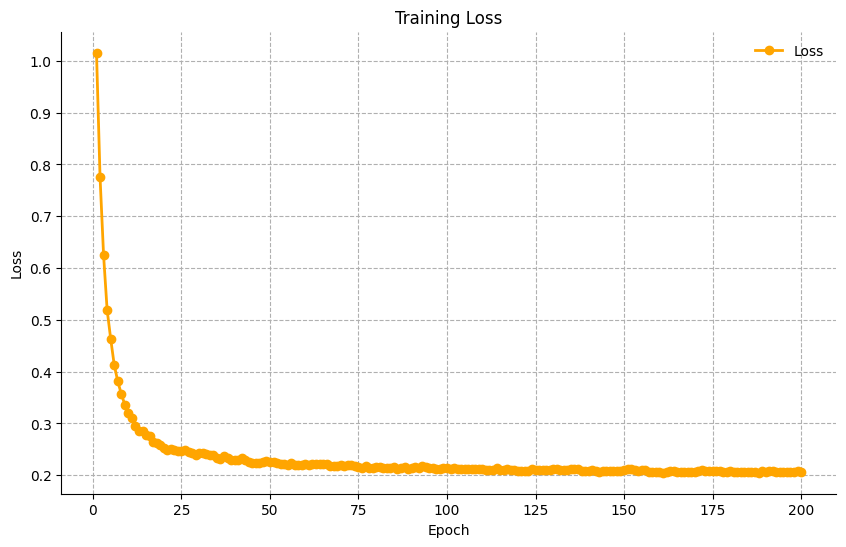

In [26]:
# Load stored data
checkpoint_path1 = "/content/checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
print(latest1)
model1.load_weights(latest1)

# Load loss history
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax
  
fig, ax = get_figure()

# Plot loss history
ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

# Add title and gridlines
ax.set_title('Training Loss')
ax.grid(True, linestyle='--')

# Show the plot
plt.show()

###### ***Model 2 - Architecture***

In [27]:
def model_2(filter_base=64, kernel_size=3):
    # Define the downsample blocks
    down_stack = [
        downsample(filter_base, kernel_size, apply_batch_norm=False),  # (base, 32, 32, 32, 64)
        downsample(filter_base * 2, kernel_size),                      # (base, 16, 16, 16, 128)
        downsample(filter_base * 3, kernel_size),                      # (base, 8, 8, 8, 256)
        downsample(filter_base * 4, kernel_size),                      # (base, 4, 4, 4, 512)
        downsample(filter_base * 5, kernel_size),                      # (base, 2, 2, 2, 1024)
    ]

    # Define the upsample blocks
    up_stack = [
        upsample(filter_base * 5, kernel_size, apply_dropout=True),     # (base, 4, 4, 4, 1024)
        upsample(filter_base * 4, kernel_size, apply_dropout=True),     # (base, 8, 8, 8, 512)
        upsample(filter_base * 3, kernel_size, apply_dropout=True),     # (base, 16, 16, 16, 256)
        upsample(filter_base * 2, kernel_size, apply_dropout=True),     # (base, 32, 32, 32, 128)
    ]

    # Define the final layer
    initializer = tf.random_normal_initializer(0., 0.02)
    final_layer = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS,
                                                  kernel_size,
                                                  strides=2,
                                                  padding='same',
                                                  kernel_initializer=initializer,
                                                  activation='tanh')  # (base, 256, 256, 3)

    concatenate = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Reverse the skips for correct order in upsampling

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])

    x = final_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [28]:
unet_model2 = model_2()

# Define the learning rate schedule
initial_learning_rate = 0.003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value based on your dataset and training requirements
    decay_rate=0.96  # Adjust this value based on your dataset and training requirements
)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer
unet_model2.compile(loss=losses.mean_squared_error, optimizer=optimizer)
unet_model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 sequential_45 (Sequential)     (None, None, None,   1728        ['input_6[0][0]']                
                                None, 64)                                                         
                                                                                                  
 sequential_46 (Sequential)     (None, None, None,   221696      ['sequential_45[0][0]']          
                                None, 128)                                                  

###### ***Model 2 - Trainning the model***

In [29]:
# Directories to store the checkpoints created
checkpoint_path_2 = "checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path_2)

# Callback to save checkpoints
cp_callback = ModelCheckpoint(
    checkpoint_path_2,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)


early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1
)

# Train the model with validation data
loss_history_2 = []
with tqdm(total=EPOCHS, desc="Training") as pbar:
    for epoch in range(EPOCHS):
        pbar.set_postfix({'Epoch': epoch+1})
        history_2 = unet_model2.fit(
            train_images,
            train_labels,
            epochs=1,
            batch_size=30,
            shuffle=True,
            validation_data=(val_images, val_labels),
            callbacks=[cp_callback, early_stopping_callback]
        )
        
        loss_history_2.append(history_2.history["loss"][0])
        
        # Clear memory after each epoch
        del history_2
        tf.keras.backend.clear_session()
        
        pbar.update(1)

with open('loss_history_2.pickle', 'wb') as f:
    pickle.dump([loss_history_2, len(loss_history_2)], f)

Training:   0%|          | 0/200 [00:00<?, ?it/s, Epoch=1]

11/11 [==============================] - ETA: 0s - loss: 1.0580
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 30s 2s/step - loss: 1.0580 - val_loss: 2.0172


Training:   0%|          | 1/200 [00:30<1:41:06, 30.48s/it, Epoch=2]

11/11 [==============================] - ETA: 0s - loss: 0.8296
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 12s 1s/step - loss: 0.8296 - val_loss: 1.9152


Training:   1%|          | 2/200 [00:51<1:22:07, 24.88s/it, Epoch=3]

11/11 [==============================] - ETA: 0s - loss: 0.6812
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.6812 - val_loss: 1.5558


Training:   2%|▏         | 3/200 [01:12<1:16:27, 23.29s/it, Epoch=4]

11/11 [==============================] - ETA: 0s - loss: 0.5710
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.5710 - val_loss: 1.6552


Training:   2%|▏         | 4/200 [01:34<1:13:26, 22.48s/it, Epoch=5]

11/11 [==============================] - ETA: 0s - loss: 0.4958
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 11s 978ms/step - loss: 0.4958 - val_loss: 1.1544


Training:   2%|▎         | 5/200 [01:45<1:00:01, 18.47s/it, Epoch=6]

11/11 [==============================] - ETA: 0s - loss: 0.4485
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 11s 986ms/step - loss: 0.4485 - val_loss: 1.0726


Training:   3%|▎         | 6/200 [02:06<1:02:37, 19.37s/it, Epoch=7]

11/11 [==============================] - ETA: 0s - loss: 0.3982
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.3982 - val_loss: 0.9186


Training:   4%|▎         | 7/200 [02:27<1:04:05, 19.92s/it, Epoch=8]

11/11 [==============================] - ETA: 0s - loss: 0.3727
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.3727 - val_loss: 0.6645


Training:   4%|▍         | 8/200 [02:48<1:04:53, 20.28s/it, Epoch=9]

11/11 [==============================] - ETA: 0s - loss: 0.3444
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.3444 - val_loss: 0.6737


Training:   4%|▍         | 9/200 [03:07<1:03:06, 19.83s/it, Epoch=10]

11/11 [==============================] - ETA: 0s - loss: 0.3189
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.3189 - val_loss: 0.6386


Training:   5%|▌         | 10/200 [03:25<1:01:24, 19.39s/it, Epoch=11]

11/11 [==============================] - ETA: 0s - loss: 0.3053
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.3053 - val_loss: 0.4707


Training:   6%|▌         | 11/200 [03:47<1:02:56, 19.98s/it, Epoch=12]

11/11 [==============================] - ETA: 0s - loss: 0.2932
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2932 - val_loss: 0.3636


Training:   6%|▌         | 12/200 [04:07<1:03:02, 20.12s/it, Epoch=13]

11/11 [==============================] - ETA: 0s - loss: 0.2878
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2878 - val_loss: 0.3894


Training:   6%|▋         | 13/200 [04:24<59:41, 19.15s/it, Epoch=14]

11/11 [==============================] - ETA: 0s - loss: 0.2785
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2785 - val_loss: 0.4135


Training:   7%|▋         | 14/200 [04:40<56:16, 18.15s/it, Epoch=15]

11/11 [==============================] - ETA: 0s - loss: 0.2720
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2720 - val_loss: 0.3605


Training:   8%|▊         | 15/200 [05:01<58:19, 18.92s/it, Epoch=16]

11/11 [==============================] - ETA: 0s - loss: 0.2675
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2675 - val_loss: 0.3763


Training:   8%|▊         | 16/200 [05:23<1:00:58, 19.88s/it, Epoch=17]

11/11 [==============================] - ETA: 0s - loss: 0.2626
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2626 - val_loss: 0.3410


Training:   8%|▊         | 17/200 [05:39<56:58, 18.68s/it, Epoch=18]

11/11 [==============================] - ETA: 0s - loss: 0.2570
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2570 - val_loss: 0.3259


Training:   9%|▉         | 18/200 [05:55<54:20, 17.91s/it, Epoch=19]

11/11 [==============================] - ETA: 0s - loss: 0.2593
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 15s 1s/step - loss: 0.2593 - val_loss: 0.3445


Training:  10%|▉         | 19/200 [06:16<56:48, 18.83s/it, Epoch=20]

11/11 [==============================] - ETA: 0s - loss: 0.2505
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2505 - val_loss: 0.3386


Training:  10%|█         | 20/200 [06:37<58:27, 19.48s/it, Epoch=21]

11/11 [==============================] - ETA: 0s - loss: 0.2499
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2499 - val_loss: 0.3170


Training:  10%|█         | 21/200 [06:55<57:06, 19.14s/it, Epoch=22]

11/11 [==============================] - ETA: 0s - loss: 0.2442
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2442 - val_loss: 0.3119


Training:  11%|█         | 22/200 [07:16<58:30, 19.72s/it, Epoch=23]

11/11 [==============================] - ETA: 0s - loss: 0.2410
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2410 - val_loss: 0.3013


Training:  12%|█▏        | 23/200 [07:37<59:08, 20.05s/it, Epoch=24]

11/11 [==============================] - ETA: 0s - loss: 0.2388
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2388 - val_loss: 0.3002


Training:  12%|█▏        | 24/200 [07:55<57:10, 19.49s/it, Epoch=25]

11/11 [==============================] - ETA: 0s - loss: 0.2397
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2397 - val_loss: 0.3022


Training:  12%|█▎        | 25/200 [08:11<53:39, 18.40s/it, Epoch=26]

11/11 [==============================] - ETA: 0s - loss: 0.2361
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2361 - val_loss: 0.3046


Training:  13%|█▎        | 26/200 [08:27<51:18, 17.69s/it, Epoch=27]

11/11 [==============================] - ETA: 0s - loss: 0.2380
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 14s 1s/step - loss: 0.2380 - val_loss: 0.3061


Training:  14%|█▎        | 27/200 [08:48<53:49, 18.67s/it, Epoch=28]

11/11 [==============================] - ETA: 0s - loss: 0.2361
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2361 - val_loss: 0.2935


Training:  14%|█▍        | 28/200 [09:09<55:28, 19.35s/it, Epoch=29]

11/11 [==============================] - ETA: 0s - loss: 0.2349
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2349 - val_loss: 0.2998


Training:  14%|█▍        | 29/200 [09:30<56:24, 19.79s/it, Epoch=30]

11/11 [==============================] - ETA: 0s - loss: 0.2315
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2315 - val_loss: 0.2868


Training:  15%|█▌        | 30/200 [09:50<56:40, 20.00s/it, Epoch=31]

11/11 [==============================] - ETA: 0s - loss: 0.2302
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2302 - val_loss: 0.2857


Training:  16%|█▌        | 31/200 [10:07<53:32, 19.01s/it, Epoch=32]

11/11 [==============================] - ETA: 0s - loss: 0.2294
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2294 - val_loss: 0.2845


Training:  16%|█▌        | 32/200 [10:28<54:32, 19.48s/it, Epoch=33]

11/11 [==============================] - ETA: 0s - loss: 0.2268
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 13s 1s/step - loss: 0.2268 - val_loss: 0.2802


Training:  16%|█▋        | 33/200 [10:48<55:26, 19.92s/it, Epoch=34]

11/11 [==============================] - ETA: 0s - loss: 0.2293
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2293 - val_loss: 0.2845


Training:  17%|█▋        | 34/200 [11:09<55:58, 20.23s/it, Epoch=35]

11/11 [==============================] - ETA: 0s - loss: 0.2287
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2287 - val_loss: 0.3009


Training:  18%|█▊        | 35/200 [11:30<56:03, 20.38s/it, Epoch=36]

11/11 [==============================] - ETA: 0s - loss: 0.2377
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2377 - val_loss: 0.2940


Training:  18%|█▊        | 36/200 [11:51<56:10, 20.55s/it, Epoch=37]

11/11 [==============================] - ETA: 0s - loss: 0.2299
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2299 - val_loss: 0.2713


Training:  18%|█▊        | 37/200 [12:12<56:13, 20.70s/it, Epoch=38]

11/11 [==============================] - ETA: 0s - loss: 0.2250
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2250 - val_loss: 0.2703


Training:  19%|█▉        | 38/200 [12:29<52:49, 19.57s/it, Epoch=39]

11/11 [==============================] - ETA: 0s - loss: 0.2254
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2254 - val_loss: 0.2840


Training:  20%|█▉        | 39/200 [13:11<1:10:06, 26.13s/it, Epoch=40]

11/11 [==============================] - ETA: 0s - loss: 0.2308
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2308 - val_loss: 0.2763


Training:  20%|██        | 40/200 [13:31<1:05:33, 24.58s/it, Epoch=41]

11/11 [==============================] - ETA: 0s - loss: 0.2212
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2212 - val_loss: 0.2723


Training:  20%|██        | 41/200 [13:53<1:02:30, 23.59s/it, Epoch=42]

11/11 [==============================] - ETA: 0s - loss: 0.2203
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2203 - val_loss: 0.2772


Training:  21%|██        | 42/200 [14:10<56:45, 21.55s/it, Epoch=43]

11/11 [==============================] - ETA: 0s - loss: 0.2231
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2231 - val_loss: 0.2783


Training:  22%|██▏       | 43/200 [14:30<55:25, 21.18s/it, Epoch=44]

11/11 [==============================] - ETA: 0s - loss: 0.2208
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2208 - val_loss: 0.2707


Training:  22%|██▏       | 44/200 [14:46<50:53, 19.58s/it, Epoch=45]

11/11 [==============================] - ETA: 0s - loss: 0.2207
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2207 - val_loss: 0.2711


Training:  22%|██▎       | 45/200 [15:07<51:40, 20.00s/it, Epoch=46]

11/11 [==============================] - ETA: 0s - loss: 0.2207
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2207 - val_loss: 0.2757


Training:  23%|██▎       | 46/200 [15:27<51:53, 20.22s/it, Epoch=47]

11/11 [==============================] - ETA: 0s - loss: 0.2234
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2234 - val_loss: 0.2713


Training:  24%|██▎       | 47/200 [15:43<48:06, 18.86s/it, Epoch=48]

11/11 [==============================] - ETA: 0s - loss: 0.2195
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2195 - val_loss: 0.2676


Training:  24%|██▍       | 48/200 [16:25<1:04:57, 25.64s/it, Epoch=49]

11/11 [==============================] - ETA: 0s - loss: 0.2180
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2180 - val_loss: 0.2672


Training:  24%|██▍       | 49/200 [16:40<56:57, 22.63s/it, Epoch=50]

11/11 [==============================] - ETA: 0s - loss: 0.2188
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2188 - val_loss: 0.2690


Training:  25%|██▌       | 50/200 [17:01<55:34, 22.23s/it, Epoch=51]

11/11 [==============================] - ETA: 0s - loss: 0.2180
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2180 - val_loss: 0.2713


Training:  26%|██▌       | 51/200 [17:22<54:16, 21.85s/it, Epoch=52]

11/11 [==============================] - ETA: 0s - loss: 0.2149
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 14s 1s/step - loss: 0.2149 - val_loss: 0.2642


Training:  26%|██▌       | 52/200 [17:37<48:32, 19.68s/it, Epoch=53]

11/11 [==============================] - ETA: 0s - loss: 0.2154
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2154 - val_loss: 0.2673


Training:  26%|██▋       | 53/200 [18:19<1:04:39, 26.39s/it, Epoch=54]

11/11 [==============================] - ETA: 0s - loss: 0.2172
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2172 - val_loss: 0.2683


Training:  27%|██▋       | 54/200 [18:40<1:00:15, 24.76s/it, Epoch=55]

11/11 [==============================] - ETA: 0s - loss: 0.2155
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2155 - val_loss: 0.2682


Training:  28%|██▊       | 55/200 [19:03<58:14, 24.10s/it, Epoch=56]

11/11 [==============================] - ETA: 0s - loss: 0.2144
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2144 - val_loss: 0.2685


Training:  28%|██▊       | 56/200 [19:24<55:34, 23.16s/it, Epoch=57]

11/11 [==============================] - ETA: 0s - loss: 0.2152
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 15s 1s/step - loss: 0.2152 - val_loss: 0.2669


Training:  28%|██▊       | 57/200 [19:39<49:35, 20.80s/it, Epoch=58]

11/11 [==============================] - ETA: 0s - loss: 0.2148
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2148 - val_loss: 0.2706


Training:  29%|██▉       | 58/200 [20:00<49:20, 20.85s/it, Epoch=59]

11/11 [==============================] - ETA: 0s - loss: 0.2132
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2132 - val_loss: 0.2659


Training:  30%|██▉       | 59/200 [20:21<49:04, 20.88s/it, Epoch=60]

11/11 [==============================] - ETA: 0s - loss: 0.2145
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2145 - val_loss: 0.2646


Training:  30%|███       | 60/200 [20:40<47:14, 20.25s/it, Epoch=61]

11/11 [==============================] - ETA: 0s - loss: 0.2177
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2177 - val_loss: 0.2693


Training:  30%|███       | 61/200 [21:01<47:33, 20.53s/it, Epoch=62]

11/11 [==============================] - ETA: 0s - loss: 0.2147
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2147 - val_loss: 0.2672


Training:  31%|███       | 62/200 [21:22<47:30, 20.66s/it, Epoch=63]

11/11 [==============================] - ETA: 0s - loss: 0.2193
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 15s 1s/step - loss: 0.2193 - val_loss: 0.2696


Training:  32%|███▏      | 63/200 [21:43<47:22, 20.75s/it, Epoch=64]

11/11 [==============================] - ETA: 0s - loss: 0.2166
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2166 - val_loss: 0.2648


Training:  32%|███▏      | 64/200 [22:04<47:09, 20.81s/it, Epoch=65]

11/11 [==============================] - ETA: 0s - loss: 0.2144
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2144 - val_loss: 0.2674


Training:  32%|███▎      | 65/200 [22:21<44:39, 19.85s/it, Epoch=66]

11/11 [==============================] - ETA: 0s - loss: 0.2130
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2130 - val_loss: 0.2641


Training:  33%|███▎      | 66/200 [22:37<41:37, 18.64s/it, Epoch=67]

11/11 [==============================] - ETA: 0s - loss: 0.2124
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2124 - val_loss: 0.2603


Training:  34%|███▎      | 67/200 [23:18<56:28, 25.48s/it, Epoch=68]

11/11 [==============================] - ETA: 0s - loss: 0.2116
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2116 - val_loss: 0.2647


Training:  34%|███▍      | 68/200 [23:40<53:26, 24.29s/it, Epoch=69]

11/11 [==============================] - ETA: 0s - loss: 0.2119
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2119 - val_loss: 0.2667


Training:  34%|███▍      | 69/200 [24:01<50:52, 23.30s/it, Epoch=70]

11/11 [==============================] - ETA: 0s - loss: 0.2116
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2116 - val_loss: 0.2640


Training:  35%|███▌      | 70/200 [24:22<48:57, 22.59s/it, Epoch=71]

11/11 [==============================] - ETA: 0s - loss: 0.2119
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2119 - val_loss: 0.2639


Training:  36%|███▌      | 71/200 [24:39<44:47, 20.83s/it, Epoch=72]

11/11 [==============================] - ETA: 0s - loss: 0.2095
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2095 - val_loss: 0.2639


Training:  36%|███▌      | 72/200 [25:00<44:39, 20.93s/it, Epoch=73]

11/11 [==============================] - ETA: 0s - loss: 0.2137
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2137 - val_loss: 0.2695


Training:  36%|███▋      | 73/200 [25:21<44:38, 21.09s/it, Epoch=74]

11/11 [==============================] - ETA: 0s - loss: 0.2124
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2124 - val_loss: 0.2676


Training:  37%|███▋      | 74/200 [25:43<44:34, 21.22s/it, Epoch=75]

11/11 [==============================] - ETA: 0s - loss: 0.2113
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2113 - val_loss: 0.2625


Training:  38%|███▊      | 75/200 [26:01<42:29, 20.40s/it, Epoch=76]

11/11 [==============================] - ETA: 0s - loss: 0.2104
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2104 - val_loss: 0.2649


Training:  38%|███▊      | 76/200 [26:23<42:46, 20.70s/it, Epoch=77]

11/11 [==============================] - ETA: 0s - loss: 0.2103
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2103 - val_loss: 0.2639


Training:  38%|███▊      | 77/200 [26:44<42:34, 20.77s/it, Epoch=78]

11/11 [==============================] - ETA: 0s - loss: 0.2104
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2104 - val_loss: 0.2658


Training:  39%|███▉      | 78/200 [27:01<40:26, 19.89s/it, Epoch=79]

11/11 [==============================] - ETA: 0s - loss: 0.2095
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2095 - val_loss: 0.2672


Training:  40%|███▉      | 79/200 [27:43<53:19, 26.44s/it, Epoch=80]

11/11 [==============================] - ETA: 0s - loss: 0.2122
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2122 - val_loss: 0.2663


Training:  40%|████      | 80/200 [28:04<49:34, 24.79s/it, Epoch=81]

11/11 [==============================] - ETA: 0s - loss: 0.2113
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2113 - val_loss: 0.2657


Training:  40%|████      | 81/200 [28:24<46:02, 23.22s/it, Epoch=82]

11/11 [==============================] - ETA: 0s - loss: 0.2178
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2178 - val_loss: 0.2722


Training:  41%|████      | 82/200 [28:45<44:29, 22.63s/it, Epoch=83]

11/11 [==============================] - ETA: 0s - loss: 0.2150
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2150 - val_loss: 0.2681


Training:  42%|████▏     | 83/200 [29:06<43:04, 22.09s/it, Epoch=84]

11/11 [==============================] - ETA: 0s - loss: 0.2151
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2151 - val_loss: 0.2651


Training:  42%|████▏     | 84/200 [29:27<42:03, 21.75s/it, Epoch=85]

11/11 [==============================] - ETA: 0s - loss: 0.2116
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2116 - val_loss: 0.2664


Training:  42%|████▎     | 85/200 [29:47<41:05, 21.44s/it, Epoch=86]

11/11 [==============================] - ETA: 0s - loss: 0.2109
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2109 - val_loss: 0.2641


Training:  43%|████▎     | 86/200 [30:09<40:37, 21.38s/it, Epoch=87]

11/11 [==============================] - ETA: 0s - loss: 0.2080
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2080 - val_loss: 0.2624


Training:  44%|████▎     | 87/200 [30:29<39:48, 21.14s/it, Epoch=88]

11/11 [==============================] - ETA: 0s - loss: 0.2087
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2087 - val_loss: 0.2629


Training:  44%|████▍     | 88/200 [30:50<39:21, 21.08s/it, Epoch=89]

11/11 [==============================] - ETA: 0s - loss: 0.2093
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2093 - val_loss: 0.2618


Training:  44%|████▍     | 89/200 [31:12<39:19, 21.26s/it, Epoch=90]

11/11 [==============================] - ETA: 0s - loss: 0.2104
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2104 - val_loss: 0.2643


Training:  45%|████▌     | 90/200 [31:33<38:54, 21.22s/it, Epoch=91]

11/11 [==============================] - ETA: 0s - loss: 0.2077
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2077 - val_loss: 0.2621


Training:  46%|████▌     | 91/200 [31:54<38:09, 21.01s/it, Epoch=92]

11/11 [==============================] - ETA: 0s - loss: 0.2078
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2078 - val_loss: 0.2631


Training:  46%|████▌     | 92/200 [32:15<37:47, 21.00s/it, Epoch=93]

11/11 [==============================] - ETA: 0s - loss: 0.2069
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2069 - val_loss: 0.2606


Training:  46%|████▋     | 93/200 [32:56<48:25, 27.15s/it, Epoch=94]

11/11 [==============================] - ETA: 0s - loss: 0.2095
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2095 - val_loss: 0.2657


Training:  47%|████▋     | 94/200 [33:17<44:52, 25.40s/it, Epoch=95]

11/11 [==============================] - ETA: 0s - loss: 0.2073
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2073 - val_loss: 0.2658


Training:  48%|████▊     | 95/200 [33:38<42:05, 24.05s/it, Epoch=96]

11/11 [==============================] - ETA: 0s - loss: 0.2089
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2089 - val_loss: 0.2664


Training:  48%|████▊     | 96/200 [33:58<39:18, 22.68s/it, Epoch=97]

11/11 [==============================] - ETA: 0s - loss: 0.2080
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2080 - val_loss: 0.2635


Training:  48%|████▊     | 97/200 [34:20<38:32, 22.45s/it, Epoch=98]

11/11 [==============================] - ETA: 0s - loss: 0.2106
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2106 - val_loss: 0.2741


Training:  49%|████▉     | 98/200 [34:41<37:24, 22.01s/it, Epoch=99]

11/11 [==============================] - ETA: 0s - loss: 0.2119
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2119 - val_loss: 0.2676


Training:  50%|████▉     | 99/200 [35:02<36:32, 21.70s/it, Epoch=100]

11/11 [==============================] - ETA: 0s - loss: 0.2131
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2131 - val_loss: 0.2681


Training:  50%|█████     | 100/200 [35:22<35:36, 21.37s/it, Epoch=101]

11/11 [==============================] - ETA: 0s - loss: 0.2120
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2120 - val_loss: 0.2630


Training:  50%|█████     | 101/200 [35:40<33:18, 20.19s/it, Epoch=102]

11/11 [==============================] - ETA: 0s - loss: 0.2082
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2082 - val_loss: 0.2657


Training:  51%|█████     | 102/200 [35:57<31:28, 19.27s/it, Epoch=103]

11/11 [==============================] - ETA: 0s - loss: 0.2072
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2072 - val_loss: 0.2613


Training:  52%|█████▏    | 103/200 [36:18<32:06, 19.86s/it, Epoch=104]

11/11 [==============================] - ETA: 0s - loss: 0.2066
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2066 - val_loss: 0.2609


Training:  52%|█████▏    | 104/200 [36:38<31:58, 19.99s/it, Epoch=105]

11/11 [==============================] - ETA: 0s - loss: 0.2072
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2072 - val_loss: 0.2647


Training:  52%|█████▎    | 105/200 [36:57<30:53, 19.51s/it, Epoch=106]

11/11 [==============================] - ETA: 0s - loss: 0.2068
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2068 - val_loss: 0.2616


Training:  53%|█████▎    | 106/200 [37:18<31:11, 19.91s/it, Epoch=107]

11/11 [==============================] - ETA: 0s - loss: 0.2095
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2095 - val_loss: 0.2642


Training:  54%|█████▎    | 107/200 [37:38<31:07, 20.08s/it, Epoch=108]

11/11 [==============================] - ETA: 0s - loss: 0.2111
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2111 - val_loss: 0.2629


Training:  54%|█████▍    | 108/200 [37:59<31:11, 20.34s/it, Epoch=109]

11/11 [==============================] - ETA: 0s - loss: 0.2081
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2081 - val_loss: 0.2631


Training:  55%|█████▍    | 109/200 [38:20<31:08, 20.53s/it, Epoch=110]

11/11 [==============================] - ETA: 0s - loss: 0.2074
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2074 - val_loss: 0.2652


Training:  55%|█████▌    | 110/200 [38:38<29:45, 19.84s/it, Epoch=111]

11/11 [==============================] - ETA: 0s - loss: 0.2062
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2062 - val_loss: 0.2610


Training:  56%|█████▌    | 111/200 [38:59<29:55, 20.17s/it, Epoch=112]

11/11 [==============================] - ETA: 0s - loss: 0.2065
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2065 - val_loss: 0.2604


Training:  56%|█████▌    | 112/200 [39:19<29:41, 20.24s/it, Epoch=113]

11/11 [==============================] - ETA: 0s - loss: 0.2071
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2071 - val_loss: 0.2612


Training:  56%|█████▋    | 113/200 [39:40<29:17, 20.20s/it, Epoch=114]

11/11 [==============================] - ETA: 0s - loss: 0.2058
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2058 - val_loss: 0.2631


Training:  57%|█████▋    | 114/200 [39:56<27:10, 18.96s/it, Epoch=115]

11/11 [==============================] - ETA: 0s - loss: 0.2070
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2070 - val_loss: 0.2632


Training:  57%|█████▊    | 115/200 [40:17<27:49, 19.64s/it, Epoch=116]

11/11 [==============================] - ETA: 0s - loss: 0.2100
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2100 - val_loss: 0.2653


Training:  58%|█████▊    | 116/200 [40:37<27:53, 19.92s/it, Epoch=117]

11/11 [==============================] - ETA: 0s - loss: 0.2085
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2085 - val_loss: 0.2669


Training:  58%|█████▊    | 117/200 [40:58<27:54, 20.17s/it, Epoch=118]

11/11 [==============================] - ETA: 0s - loss: 0.2065
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2065 - val_loss: 0.2602


Training:  59%|█████▉    | 118/200 [41:19<27:54, 20.42s/it, Epoch=119]

11/11 [==============================] - ETA: 0s - loss: 0.2062
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 23s 2s/step - loss: 0.2062 - val_loss: 0.2643


Training:  60%|█████▉    | 119/200 [41:42<28:30, 21.11s/it, Epoch=120]

11/11 [==============================] - ETA: 0s - loss: 0.2056
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2056 - val_loss: 0.2676


Training:  60%|██████    | 120/200 [42:03<28:09, 21.11s/it, Epoch=121]

11/11 [==============================] - ETA: 0s - loss: 0.2060
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2060 - val_loss: 0.2647


Training:  60%|██████    | 121/200 [42:24<27:45, 21.09s/it, Epoch=122]

11/11 [==============================] - ETA: 0s - loss: 0.2082
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2082 - val_loss: 0.2671


Training:  61%|██████    | 122/200 [42:42<26:08, 20.11s/it, Epoch=123]

11/11 [==============================] - ETA: 0s - loss: 0.2073
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2073 - val_loss: 0.2627


Training:  62%|██████▏   | 123/200 [43:04<26:26, 20.60s/it, Epoch=124]

11/11 [==============================] - ETA: 0s - loss: 0.2059
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2059 - val_loss: 0.2645


Training:  62%|██████▏   | 124/200 [43:25<26:22, 20.82s/it, Epoch=125]

11/11 [==============================] - ETA: 0s - loss: 0.2071
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2071 - val_loss: 0.2654


Training:  62%|██████▎   | 125/200 [43:41<24:21, 19.49s/it, Epoch=126]

11/11 [==============================] - ETA: 0s - loss: 0.2057
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2057 - val_loss: 0.2677


Training:  63%|██████▎   | 126/200 [44:03<24:50, 20.14s/it, Epoch=127]

11/11 [==============================] - ETA: 0s - loss: 0.2044
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2044 - val_loss: 0.2616


Training:  64%|██████▎   | 127/200 [44:24<24:54, 20.47s/it, Epoch=128]

11/11 [==============================] - ETA: 0s - loss: 0.2039
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 1s/step - loss: 0.2039 - val_loss: 0.2642


Training:  64%|██████▍   | 128/200 [44:41<23:06, 19.26s/it, Epoch=129]

11/11 [==============================] - ETA: 0s - loss: 0.2051
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2051 - val_loss: 0.2634


Training:  64%|██████▍   | 129/200 [45:02<23:31, 19.88s/it, Epoch=130]

11/11 [==============================] - ETA: 0s - loss: 0.2033
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2033 - val_loss: 0.2639


Training:  65%|██████▌   | 130/200 [45:23<23:30, 20.15s/it, Epoch=131]

11/11 [==============================] - ETA: 0s - loss: 0.2043
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2043 - val_loss: 0.2644


Training:  66%|██████▌   | 131/200 [45:41<22:21, 19.45s/it, Epoch=132]

11/11 [==============================] - ETA: 0s - loss: 0.2034
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2034 - val_loss: 0.2636


Training:  66%|██████▌   | 132/200 [46:02<22:41, 20.02s/it, Epoch=133]

11/11 [==============================] - ETA: 0s - loss: 0.2042
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2042 - val_loss: 0.2648


Training:  66%|██████▋   | 133/200 [46:23<22:41, 20.32s/it, Epoch=134]

11/11 [==============================] - ETA: 0s - loss: 0.2051
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 2s/step - loss: 0.2051 - val_loss: 0.2673


Training:  67%|██████▋   | 134/200 [46:40<21:07, 19.20s/it, Epoch=135]

11/11 [==============================] - ETA: 0s - loss: 0.2086
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2086 - val_loss: 0.2671


Training:  68%|██████▊   | 135/200 [47:01<21:23, 19.75s/it, Epoch=136]

11/11 [==============================] - ETA: 0s - loss: 0.2079
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2079 - val_loss: 0.2640


Training:  68%|██████▊   | 136/200 [47:21<21:21, 20.03s/it, Epoch=137]

11/11 [==============================] - ETA: 0s - loss: 0.2058
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2058 - val_loss: 0.2634


Training:  68%|██████▊   | 137/200 [47:39<20:20, 19.37s/it, Epoch=138]

11/11 [==============================] - ETA: 0s - loss: 0.2051
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2051 - val_loss: 0.2624


Training:  69%|██████▉   | 138/200 [48:00<20:29, 19.84s/it, Epoch=139]

11/11 [==============================] - ETA: 0s - loss: 0.2041
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2041 - val_loss: 0.2632


Training:  70%|██████▉   | 139/200 [48:41<26:45, 26.31s/it, Epoch=140]

11/11 [==============================] - ETA: 0s - loss: 0.2037
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 24s 2s/step - loss: 0.2037 - val_loss: 0.2613


Training:  70%|███████   | 140/200 [49:06<25:43, 25.73s/it, Epoch=141]

11/11 [==============================] - ETA: 0s - loss: 0.2036
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2036 - val_loss: 0.2630


Training:  70%|███████   | 141/200 [49:47<29:56, 30.44s/it, Epoch=142]

11/11 [==============================] - ETA: 0s - loss: 0.2027
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2027 - val_loss: 0.2633


Training:  71%|███████   | 142/200 [50:08<26:40, 27.60s/it, Epoch=143]

11/11 [==============================] - ETA: 0s - loss: 0.2059
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2059 - val_loss: 0.2660


Training:  72%|███████▏  | 143/200 [50:29<24:19, 25.61s/it, Epoch=144]

11/11 [==============================] - ETA: 0s - loss: 0.2049
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2049 - val_loss: 0.2675


Training:  72%|███████▏  | 144/200 [50:50<22:36, 24.22s/it, Epoch=145]

11/11 [==============================] - ETA: 0s - loss: 0.2033
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2033 - val_loss: 0.2650


Training:  72%|███████▎  | 145/200 [51:10<20:56, 22.84s/it, Epoch=146]

11/11 [==============================] - ETA: 0s - loss: 0.2052
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2052 - val_loss: 0.2677


Training:  73%|███████▎  | 146/200 [51:31<20:12, 22.45s/it, Epoch=147]

11/11 [==============================] - ETA: 0s - loss: 0.2049
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2049 - val_loss: 0.2628


Training:  74%|███████▎  | 147/200 [52:13<24:51, 28.15s/it, Epoch=148]

11/11 [==============================] - ETA: 0s - loss: 0.2037
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2037 - val_loss: 0.2632


Training:  74%|███████▍  | 148/200 [52:33<22:25, 25.87s/it, Epoch=149]

11/11 [==============================] - ETA: 0s - loss: 0.2034
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2034 - val_loss: 0.2636


Training:  74%|███████▍  | 149/200 [53:15<25:57, 30.54s/it, Epoch=150]

11/11 [==============================] - ETA: 0s - loss: 0.2032
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 23s 2s/step - loss: 0.2032 - val_loss: 0.2645


Training:  75%|███████▌  | 150/200 [53:38<23:34, 28.28s/it, Epoch=151]

11/11 [==============================] - ETA: 0s - loss: 0.2027
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 26s 2s/step - loss: 0.2027 - val_loss: 0.2637


Training:  76%|███████▌  | 151/200 [54:19<26:19, 32.23s/it, Epoch=152]

11/11 [==============================] - ETA: 0s - loss: 0.2046
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2046 - val_loss: 0.2649


Training:  76%|███████▌  | 152/200 [54:40<22:56, 28.68s/it, Epoch=153]

11/11 [==============================] - ETA: 0s - loss: 0.2046
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2046 - val_loss: 0.2670


Training:  76%|███████▋  | 153/200 [55:01<20:38, 26.36s/it, Epoch=154]

11/11 [==============================] - ETA: 0s - loss: 0.2031
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2031 - val_loss: 0.2637


Training:  77%|███████▋  | 154/200 [55:21<18:55, 24.69s/it, Epoch=155]

11/11 [==============================] - ETA: 0s - loss: 0.2038
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2038 - val_loss: 0.2654


Training:  78%|███████▊  | 155/200 [55:43<17:44, 23.66s/it, Epoch=156]

11/11 [==============================] - ETA: 0s - loss: 0.2033
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2033 - val_loss: 0.2688


Training:  78%|███████▊  | 156/200 [56:04<16:45, 22.85s/it, Epoch=157]

11/11 [==============================] - ETA: 0s - loss: 0.2023
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2023 - val_loss: 0.2633


Training:  78%|███████▊  | 157/200 [56:45<20:22, 28.42s/it, Epoch=158]

11/11 [==============================] - ETA: 0s - loss: 0.2021
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2021 - val_loss: 0.2638


Training:  79%|███████▉  | 158/200 [57:06<18:16, 26.11s/it, Epoch=159]

11/11 [==============================] - ETA: 0s - loss: 0.2042
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2042 - val_loss: 0.2666


Training:  80%|███████▉  | 159/200 [57:27<16:46, 24.56s/it, Epoch=160]

11/11 [==============================] - ETA: 0s - loss: 0.2047
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2047 - val_loss: 0.2654


Training:  80%|████████  | 160/200 [57:48<15:38, 23.47s/it, Epoch=161]

11/11 [==============================] - ETA: 0s - loss: 0.2037
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2037 - val_loss: 0.2666


Training:  80%|████████  | 161/200 [58:09<14:45, 22.72s/it, Epoch=162]

11/11 [==============================] - ETA: 0s - loss: 0.2045
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2045 - val_loss: 0.2639


Training:  81%|████████  | 162/200 [58:30<14:03, 22.19s/it, Epoch=163]

11/11 [==============================] - ETA: 0s - loss: 0.2051
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2051 - val_loss: 0.2677


Training:  82%|████████▏ | 163/200 [58:51<13:31, 21.92s/it, Epoch=164]

11/11 [==============================] - ETA: 0s - loss: 0.2063
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2063 - val_loss: 0.2671


Training:  82%|████████▏ | 164/200 [59:12<13:03, 21.75s/it, Epoch=165]

11/11 [==============================] - ETA: 0s - loss: 0.2098
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 22s 2s/step - loss: 0.2098 - val_loss: 0.2707


Training:  82%|████████▎ | 165/200 [59:54<16:08, 27.67s/it, Epoch=166]

11/11 [==============================] - ETA: 0s - loss: 0.2058
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2058 - val_loss: 0.2656


Training:  83%|████████▎ | 166/200 [1:00:16<14:41, 25.94s/it, Epoch=167]

11/11 [==============================] - ETA: 0s - loss: 0.2049
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2049 - val_loss: 0.2679


Training:  84%|████████▎ | 167/200 [1:00:37<13:33, 24.64s/it, Epoch=168]

11/11 [==============================] - ETA: 0s - loss: 0.2035
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2035 - val_loss: 0.2663


Training:  84%|████████▍ | 168/200 [1:01:19<15:49, 29.69s/it, Epoch=169]

11/11 [==============================] - ETA: 0s - loss: 0.2036
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2036 - val_loss: 0.2631


Training:  84%|████████▍ | 169/200 [1:01:40<13:59, 27.07s/it, Epoch=170]

11/11 [==============================] - ETA: 0s - loss: 0.2048
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2048 - val_loss: 0.2685


Training:  85%|████████▌ | 170/200 [1:02:01<12:40, 25.33s/it, Epoch=171]

11/11 [==============================] - ETA: 0s - loss: 0.2059
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2059 - val_loss: 0.2650


Training:  86%|████████▌ | 171/200 [1:02:22<11:36, 24.02s/it, Epoch=172]

11/11 [==============================] - ETA: 0s - loss: 0.2039
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 16s 2s/step - loss: 0.2039 - val_loss: 0.2654


Training:  86%|████████▌ | 172/200 [1:02:38<10:08, 21.75s/it, Epoch=173]

11/11 [==============================] - ETA: 0s - loss: 0.2029
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2029 - val_loss: 0.2666


Training:  86%|████████▋ | 173/200 [1:03:00<09:42, 21.59s/it, Epoch=174]

11/11 [==============================] - ETA: 0s - loss: 0.2020
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2020 - val_loss: 0.2631


Training:  87%|████████▋ | 174/200 [1:03:20<09:16, 21.40s/it, Epoch=175]

11/11 [==============================] - ETA: 0s - loss: 0.2020
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2020 - val_loss: 0.2651


Training:  88%|████████▊ | 175/200 [1:03:37<08:19, 19.97s/it, Epoch=176]

11/11 [==============================] - ETA: 0s - loss: 0.2016
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2016 - val_loss: 0.2642


Training:  88%|████████▊ | 176/200 [1:03:58<08:04, 20.17s/it, Epoch=177]

11/11 [==============================] - ETA: 0s - loss: 0.2026
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2026 - val_loss: 0.2667


Training:  88%|████████▊ | 177/200 [1:04:18<07:47, 20.32s/it, Epoch=178]

11/11 [==============================] - ETA: 0s - loss: 0.2012
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2012 - val_loss: 0.2666


Training:  89%|████████▉ | 178/200 [1:04:37<07:16, 19.85s/it, Epoch=179]

11/11 [==============================] - ETA: 0s - loss: 0.2022
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2022 - val_loss: 0.2674


Training:  90%|████████▉ | 179/200 [1:04:58<07:05, 20.25s/it, Epoch=180]

11/11 [==============================] - ETA: 0s - loss: 0.2037
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2037 - val_loss: 0.2654


Training:  90%|█████████ | 180/200 [1:05:19<06:46, 20.33s/it, Epoch=181]

11/11 [==============================] - ETA: 0s - loss: 0.2040
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2040 - val_loss: 0.2613


Training:  90%|█████████ | 181/200 [1:05:38<06:21, 20.10s/it, Epoch=182]

11/11 [==============================] - ETA: 0s - loss: 0.2030
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2030 - val_loss: 0.2641


Training:  91%|█████████ | 182/200 [1:05:59<06:06, 20.36s/it, Epoch=183]

11/11 [==============================] - ETA: 0s - loss: 0.2019
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2019 - val_loss: 0.2639


Training:  92%|█████████▏| 183/200 [1:06:20<05:49, 20.56s/it, Epoch=184]

11/11 [==============================] - ETA: 0s - loss: 0.2019
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2019 - val_loss: 0.2629


Training:  92%|█████████▏| 184/200 [1:06:41<05:30, 20.67s/it, Epoch=185]

11/11 [==============================] - ETA: 0s - loss: 0.2030
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2030 - val_loss: 0.2642


Training:  92%|█████████▎| 185/200 [1:06:59<04:58, 19.88s/it, Epoch=186]

11/11 [==============================] - ETA: 0s - loss: 0.2031
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2031 - val_loss: 0.2643


Training:  93%|█████████▎| 186/200 [1:07:20<04:42, 20.15s/it, Epoch=187]

11/11 [==============================] - ETA: 0s - loss: 0.2029
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2029 - val_loss: 0.2652


Training:  94%|█████████▎| 187/200 [1:07:41<04:25, 20.39s/it, Epoch=188]

11/11 [==============================] - ETA: 0s - loss: 0.2016
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 18s 2s/step - loss: 0.2016 - val_loss: 0.2634


Training:  94%|█████████▍| 188/200 [1:07:59<03:56, 19.73s/it, Epoch=189]

11/11 [==============================] - ETA: 0s - loss: 0.2012
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2012 - val_loss: 0.2634


Training:  94%|█████████▍| 189/200 [1:08:20<03:40, 20.08s/it, Epoch=190]

11/11 [==============================] - ETA: 0s - loss: 0.2007
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 17s 2s/step - loss: 0.2007 - val_loss: 0.2613


Training:  95%|█████████▌| 190/200 [1:08:41<03:23, 20.34s/it, Epoch=191]

11/11 [==============================] - ETA: 0s - loss: 0.2022
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2022 - val_loss: 0.2661


Training:  96%|█████████▌| 191/200 [1:09:02<03:04, 20.53s/it, Epoch=192]

11/11 [==============================] - ETA: 0s - loss: 0.2012
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2012 - val_loss: 0.2640


Training:  96%|█████████▌| 192/200 [1:09:22<02:43, 20.43s/it, Epoch=193]

11/11 [==============================] - ETA: 0s - loss: 0.2017
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2017 - val_loss: 0.2651


Training:  96%|█████████▋| 193/200 [1:09:43<02:23, 20.53s/it, Epoch=194]

11/11 [==============================] - ETA: 0s - loss: 0.2014
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2014 - val_loss: 0.2691


Training:  97%|█████████▋| 194/200 [1:10:03<02:02, 20.46s/it, Epoch=195]

11/11 [==============================] - ETA: 0s - loss: 0.2009
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 24s 2s/step - loss: 0.2009 - val_loss: 0.2647


Training:  98%|█████████▊| 195/200 [1:10:45<02:13, 26.76s/it, Epoch=196]

11/11 [==============================] - ETA: 0s - loss: 0.2022
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2022 - val_loss: 0.2660


Training:  98%|█████████▊| 196/200 [1:11:06<01:39, 24.96s/it, Epoch=197]

11/11 [==============================] - ETA: 0s - loss: 0.2008
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2008 - val_loss: 0.2695


Training:  98%|█████████▊| 197/200 [1:11:26<01:11, 23.71s/it, Epoch=198]

11/11 [==============================] - ETA: 0s - loss: 0.2009
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 19s 2s/step - loss: 0.2009 - val_loss: 0.2674


Training:  99%|█████████▉| 198/200 [1:11:45<00:44, 22.31s/it, Epoch=199]

11/11 [==============================] - ETA: 0s - loss: 0.2011
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 21s 2s/step - loss: 0.2011 - val_loss: 0.2690


Training: 100%|█████████▉| 199/200 [1:12:07<00:22, 22.07s/it, Epoch=200]

11/11 [==============================] - ETA: 0s - loss: 0.2022
Epoch 1: saving model to checkpoint_model_2/cp-0001.ckpt
11/11 [==============================] - 20s 2s/step - loss: 0.2022 - val_loss: 0.2697


Training: 100%|██████████| 200/200 [1:12:27<00:00, 21.74s/it, Epoch=200]


/content/checkpoint_model_2/cp-0001.ckpt


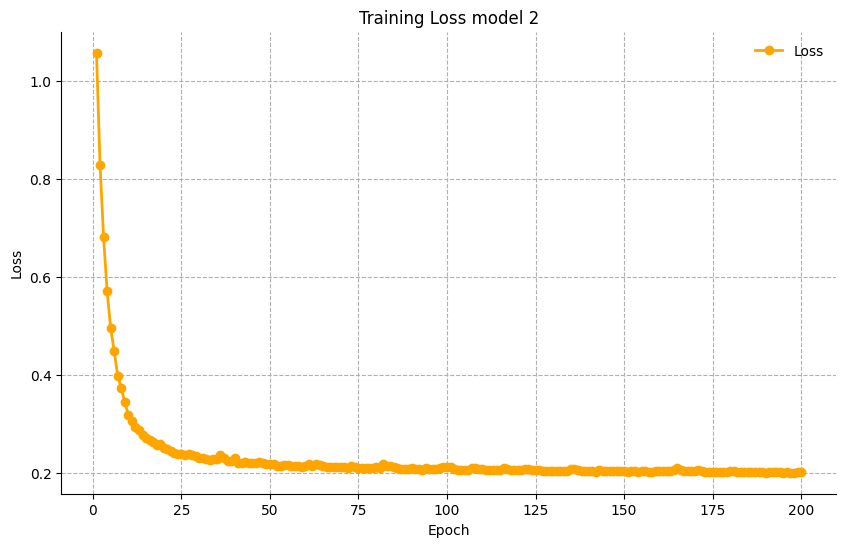

In [30]:
# Load stored data
checkpoint_path2 = "/content/checkpoint_model_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
model2 = model_2()
model2.compile(loss='mean_squared_error', optimizer='adam')
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
print(latest2)
model2.load_weights(latest2)

# Load loss history
with open('loss_history_2.pickle', 'rb') as f:
    [loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1, figsize=(10, 6))  # Adjust the figsize as desired
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax
  
fig, ax = get_figure()

# Plot loss history
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2, color="orange", label="Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

# Add title and gridlines
ax.set_title('Training Loss model 2')
ax.grid(True, linestyle='--')

# Show the plot
plt.show()

##### ***Architecture Comparison***

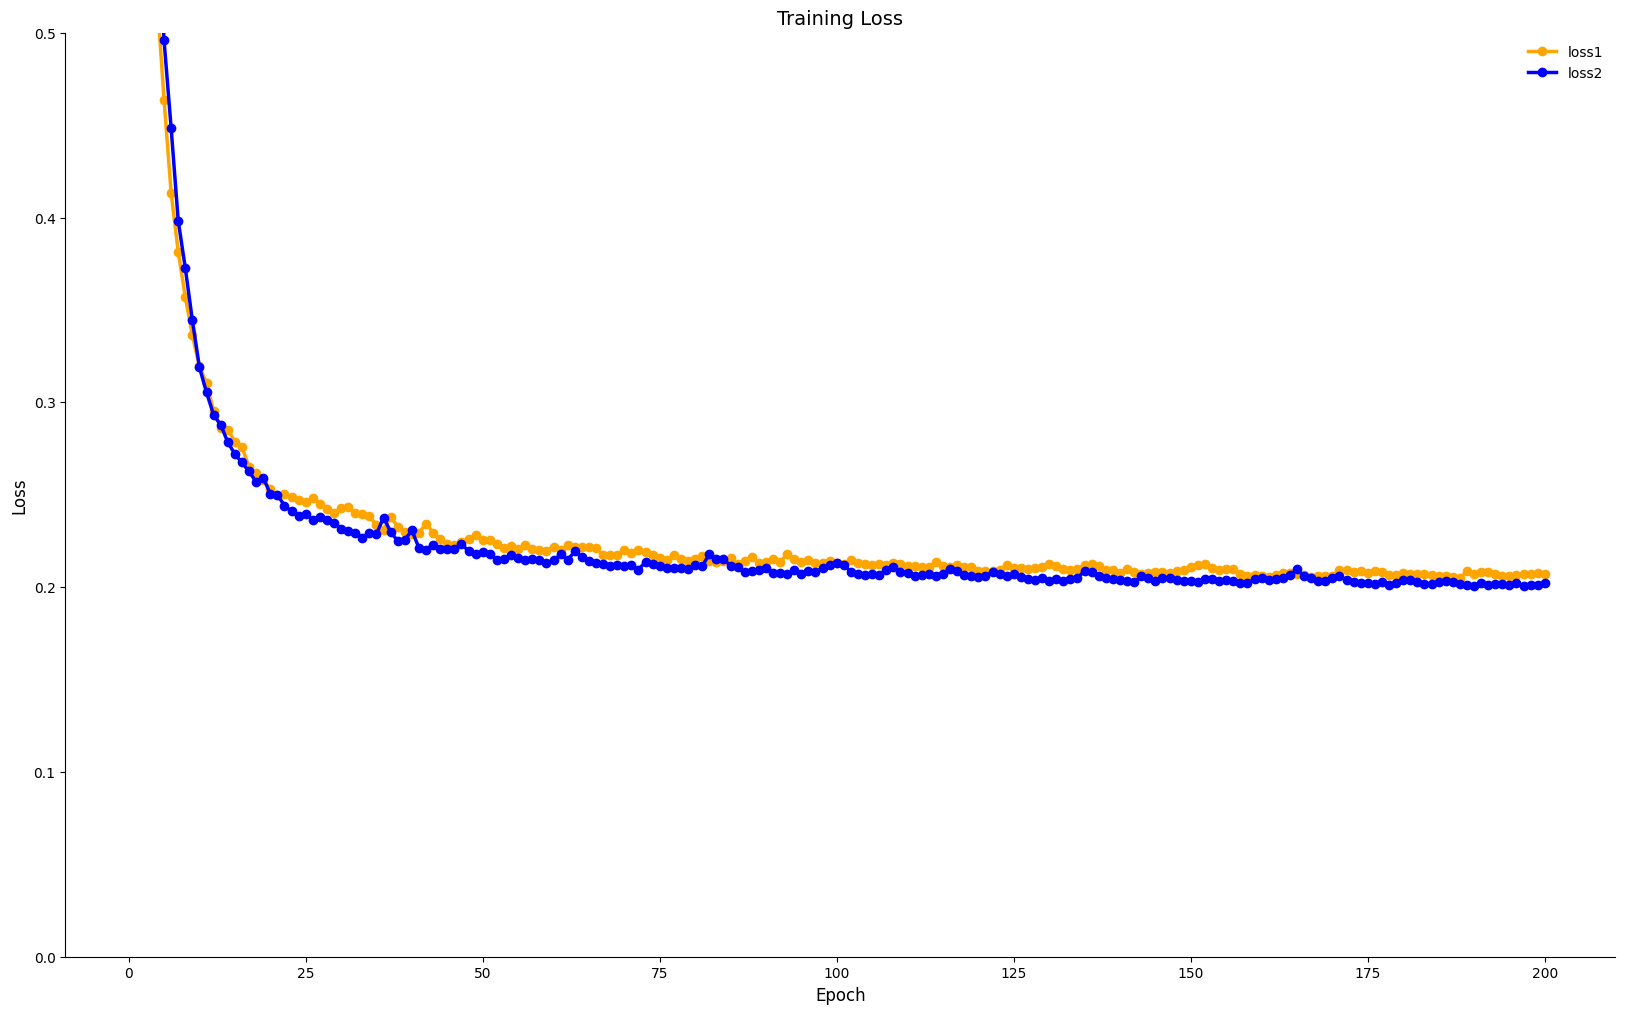

In [32]:
with open('loss_history_1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

with open('loss_history_2.pickle', 'rb') as f:
    [loss_history2, epochs_train2] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks, because those are ugly
    """
    fig, ax = plt.subplots(1, figsize=(20, 12))
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax
  
fig, ax = get_figure()

ax.plot(np.arange(epochs_train1) + 1, loss_history1, marker="o", linewidth=2.5, color="orange", label="loss1")
ax.plot(np.arange(epochs_train2) + 1, loss_history2, marker="o", linewidth=2.5, color="blue", label="loss2")
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss', fontsize=14)
ax.legend(frameon=False, fontsize=10)
plt.ylim((0, 0.5))

plt.show()


##### ***Model prediction 2***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 1s 524ms/step
Shape of testing data: (1, 64, 64, 64, 1)


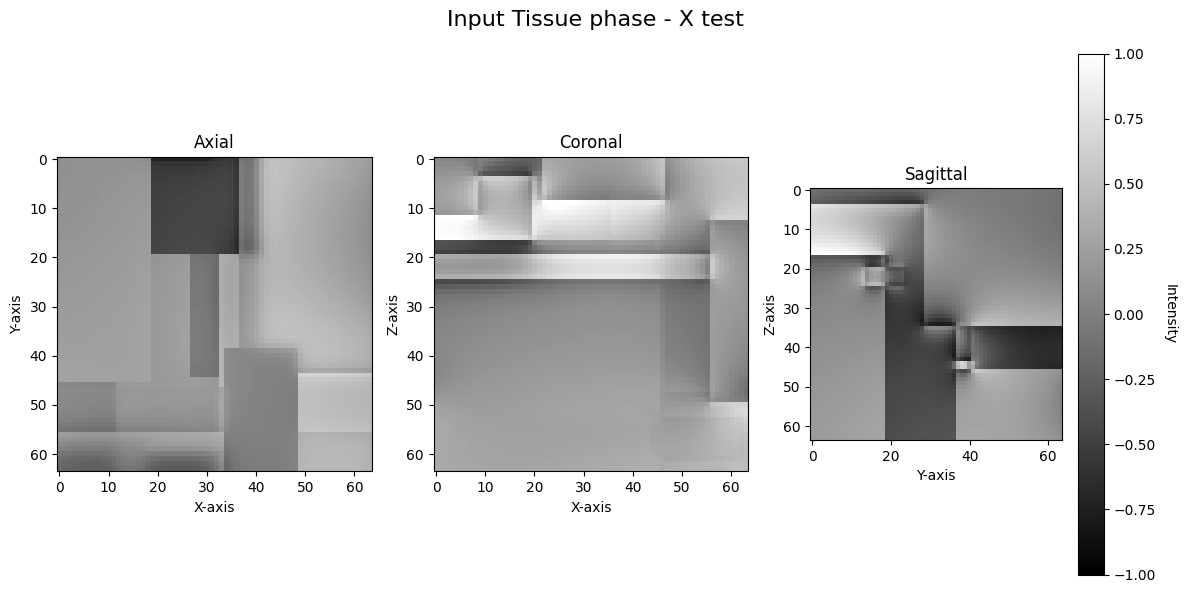

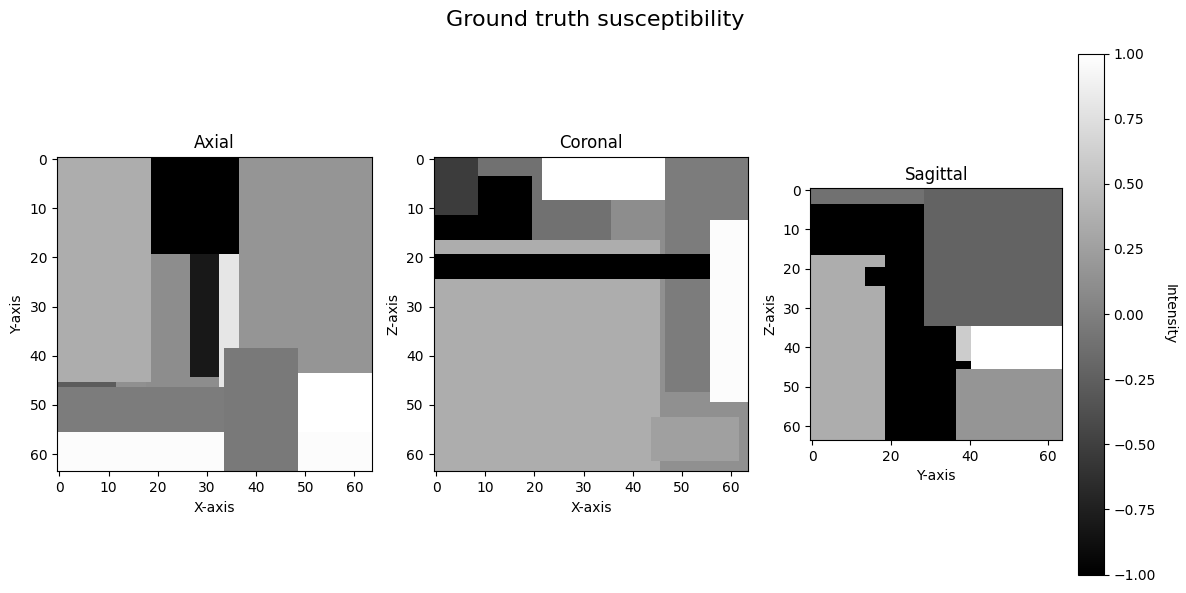

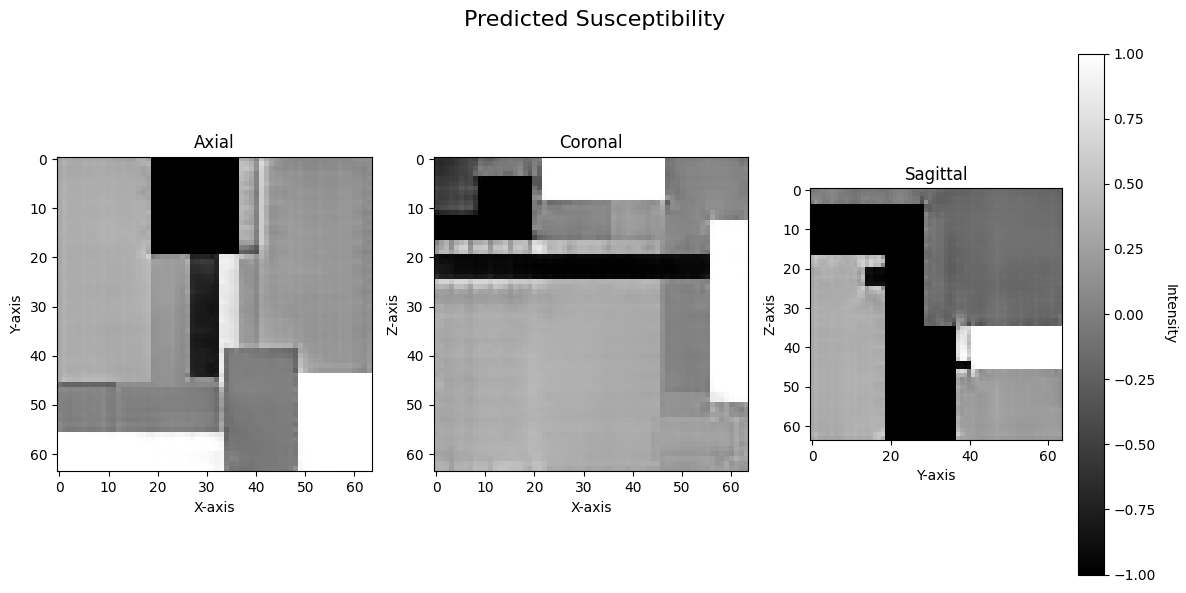

In [35]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model2.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


(1, 160, 160, 160, 1)
1/1 [==============================] - 0s 41ms/step
(1, 160, 160, 160, 1)


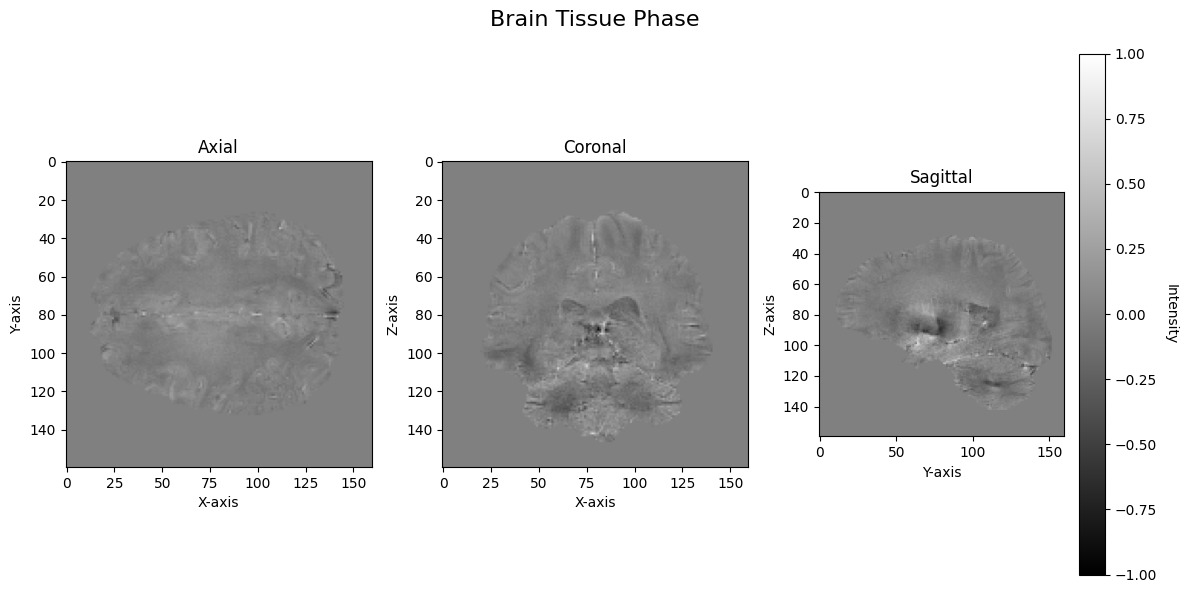

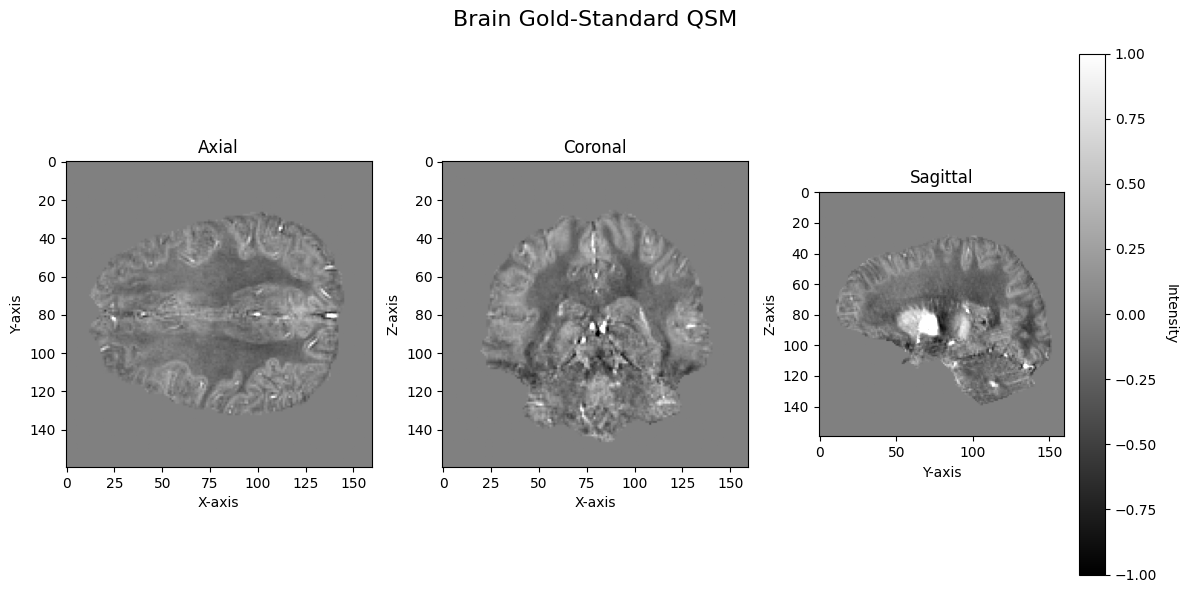

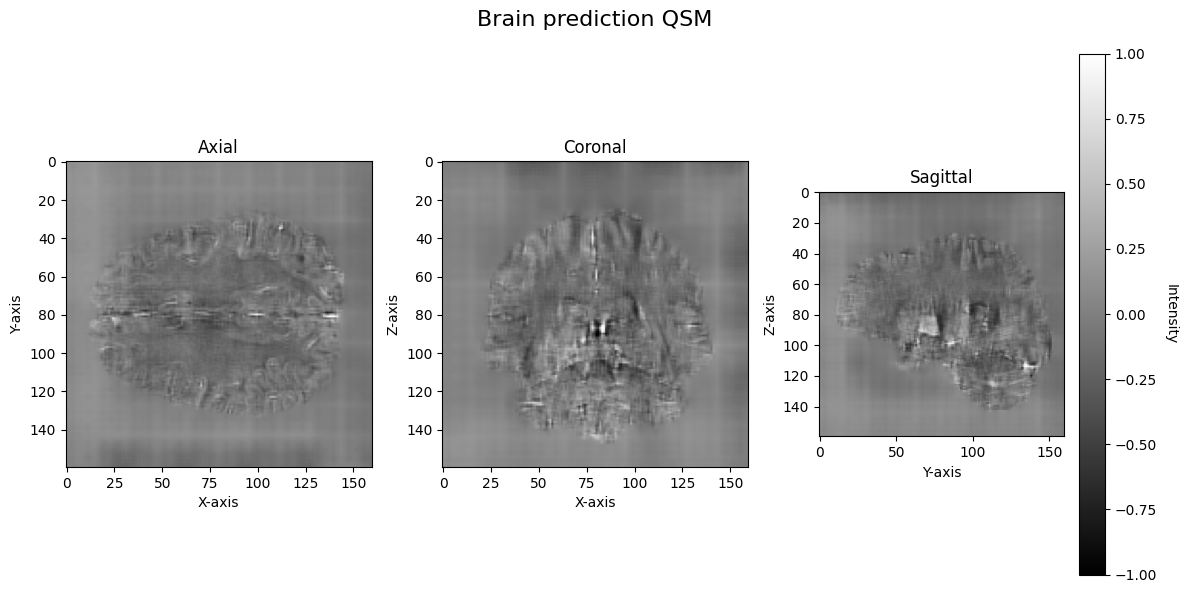

In [38]:
# and predicting on the brain data?
X_test = tissue_phase_brain[np.newaxis, :, :, :, np.newaxis] * 10
print(X_test.shape)

y_pred = unet_model2.predict(X_test)

print(y_pred.shape)




view_slices_3d(X_test[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain Tissue Phase')
view_slices_3d(gold_standard_qsm*10, slice_nbr=100, vmin=-1, vmax=1, title='Brain Gold-Standard QSM') 
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=100, vmin=-1, vmax=1, title='Brain prediction QSM') 